# Method 1

Combining building footprint data and roof point clouds. Using the z-value from the roof point clouds and the xy-polygon from the buidling footprint to create LoD2 building models using Matplotlib. 

### Imported libraries


In [2]:
import os
import numpy as np
import geopandas as gpd
import laspy as lp
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
from sklearn.linear_model import RANSACRegressor

### Data 

In [3]:
pointcloud_data = "sample_roofdata_50"
footprint_data = "cropped_data/clipped_final_area.shp"

### Roof point cloud data

In [4]:
roof_polygons = []
tolerance = 0.15

#reading laz file using Laspy
for roof in os.listdir(pointcloud_data):
    if roof.endswith(".laz"):
        file_path = os.path.join(pointcloud_data, roof)
        
        with lp.open(file_path, laz_backend=lp.LazBackend) as fh:
            point_count = fh.header.point_count
            las_data = fh.read()
            x = las_data.x
            y = las_data.y
            z = las_data.z
            max_z = np.max(z)
            min_z = np.min(z)

            # extract points near the upper edge
            upper_edge_mask = (z >= max_z - tolerance)
            upper_x = np.array(x[upper_edge_mask])
            upper_y = np.array(y[upper_edge_mask])
            upper_z = np.array(z[upper_edge_mask])

            # extract points near the lower edge
            lower_edge_mask = (z <= min_z + tolerance)
            lower_x = np.array(x[lower_edge_mask])
            lower_y = np.array(y[lower_edge_mask])
            lower_z = np.array(z[lower_edge_mask])

            # fit line to upper edge
            def fit_line(x_vals, y_vals):
                if len(x_vals) > 2:  # needs at least two points to fit a line
                    X = np.array(x_vals).reshape(-1, 1)  
                    y_values = np.array(y_vals).reshape(-1, 1)
                    model = RANSACRegressor() #using RANSAC algorithm from Sklearn to fit the line
                    model.fit(X, y_values)
                    line_y_pred = model.predict(X)  
                    return line_y_pred.flatten()
                else:
                    return y_vals  

            upper_line_y = fit_line(upper_x, upper_y) 
            upper_line = LineString(zip(upper_x, upper_line_y))

            roof_polygons.append({
                "file_name": roof,
                "point_count": point_count,
                "x": x,
                "y": y,
                "z": z,
                "min_z": min_z,
                "max_z": max_z,
                "upper_line": upper_line,
            })

         
pointcloud = gpd.GeoDataFrame(roof_polygons) #create geodataframe 
pointcloud["mean_point"] = pointcloud.apply(lambda row: Point(np.mean(row["x"]), np.mean(row["y"])), axis=1)
pointcloud = pointcloud.set_geometry("mean_point")
pointcloud = pointcloud.set_crs('epsg:25832')

print(pointcloud.crs)
pointcloud.head()

epsg:25832


file_name  point_count  \
0  182130478.laz         1431   
1   10566010.laz          610   
2  182250287.laz         2762   
3  182213209.laz         3732   
4  182461407.laz         1463   

                                                   x  \
0  [574233.04, 574233.29, 574233.55, 574232.86, 5...   
1  [571975.54, 571975.3200000001, 571975.09, 5719...   
2  [571158.34, 571158.62, 571158.86, 571159.11, 5...   
3  [570541.56, 570540.83, 570539.9, 570538.23, 57...   
4  [566638.55, 566638.33, 566638.13, 566637.72, 5...   

                                                   y  \
0  [7035248.890000001, 7035249.4, 7035249.91, 703...   
1  [7030582.08, 7030581.68, 7030581.26, 7030581.2...   
2  [7032974.55, 7032975.08, 7032975.57, 7032976.0...   
3  [7033708.16, 7033707.86, 7033707.5, 7033706.82...   
4  [7025571.65, 7025571.23, 7025570.83, 7025570.0...   

                                                   z   min_z   max_z  \
0  [21.0, 20.57, 20.080000000000002, 22.61, 22.12...   19.71   23.79   
1  [132.32, 132.18, 132.04, 132.04, 132.53, 132.2...  131.90  133.27   
2  [119.38, 119.05, 118.73, 118.41, 119.42, 119.0...  115.84  119.47   
3  [60.94, 60.63, 60.61, 60.69, 60.71, 60.71, 60....   58.96   62.67   
4  [184.47, 184.24, 184.31, 183.75, 183.52, 183.3...  182.81  184.72   

                                          upper_line  \
0  LINESTRING (574239.25 7035244.455674204, 57424...   
1  LINESTRING (571978 7030578.67133344, 571977.78...   
2  LINESTRING (571158.34 7032974.378121717, 57115...   
3  LINESTRING (570536.38 7033728.334750269, 57054...   
4  LINESTRING (566639.15 7025570.779656272, 56664...   

                       mean_point  
0  POINT (574242.791 7035243.692)  
1  POINT (571977.761 7030578.065)  
2  POINT (571163.068 7032971.392)  
3  POINT (570542.282 7033712.057)  
4  POINT (566645.963 7025564.012)

### Building footprint data

In [5]:
footprint = gpd.read_file(footprint_data)
footprint = footprint.to_crs(25832)

#Get corners from buildings
def extract_corners(polygon):
    if polygon.geom_type == "Polygon":
        return [Point(x, y) for x, y in polygon.exterior.coords] 
    elif polygon.geom_type == "MultiPolygon":
        return [Point(x, y) for poly in polygon.geoms for x, y in poly.exterior.coords] 
    else:
        return None  

footprint["corners"] = footprint["geometry"].apply(extract_corners)
footprint = footprint.to_crs(25832)

footprint.head()

osm_id  code    fclass                       name    type  \
0   5079678  1500  building           Trondheim rådhus  public   
1  17693566  1500  building                     Donjon    None   
2  19145582  1500  building        Trondheim døvekirke  church   
3  22811509  1500  building        Byåsen butikksenter  retail   
4  22915083  1500  building  Bunnpris & Gourmet Tyholt  retail   

                                            geometry  \
0  POLYGON ((569712.622 7034071.974, 569716.694 7...   
1  POLYGON ((570407.846 7033920.271, 570393.136 7...   
2  POLYGON ((569828.869 7032858.683, 569829.349 7...   
3  POLYGON ((567499.029 7032887.369, 567499.389 7...   
4  POLYGON ((571438.583 7033094.082, 571441.699 7...   

                                             corners  
0  [POINT (569712.6216782562 7034071.974002578), ...  
1  [POINT (570407.8464293351 7033920.2707800865),...  
2  [POINT (569828.8686698809 7032858.682878285), ...  
3  [POINT (567499.0288805708 7032887.368571803), ...  
4  [POINT (571438.5825759375 7033094.081795346), ...

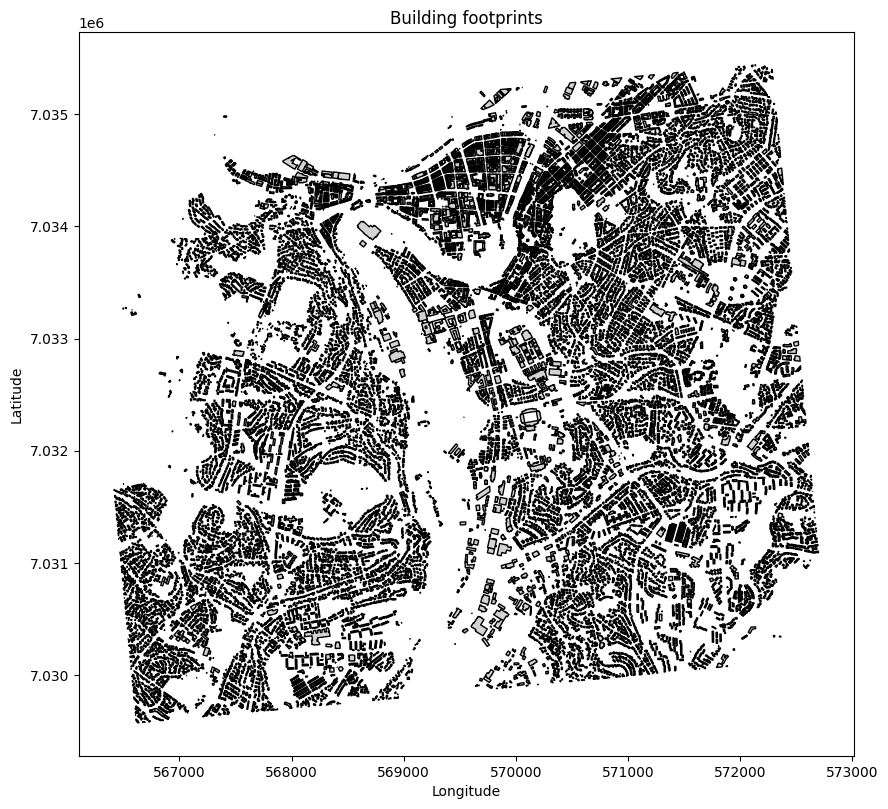

In [6]:
# Visualization of the building footprints in Trondheim

fig, ax = plt.subplots(figsize=(10, 10))
footprint.plot(ax=ax, color="lightgrey", edgecolor="black")


plt.title("Building footprints")
plt.xlabel("Longitude")

plt.ylabel("Latitude")
plt.show()

### Combine data
Dataframe where buildings is connected with the nearest roof

In [7]:
footprint = footprint.to_crs(25832) #convert to UTM32N
pointcloud = pointcloud.to_crs(25832) #convert to UTM32N
combined_footprint_pointcloud: gpd.GeoDataFrame = footprint.sjoin_nearest(pointcloud, how="inner", distance_col="distance", max_distance=5)
combined_footprint_pointcloud.head()

osm_id  code    fclass  name        type  \
613   88741098  1500  building  None  apartments   
1686  92541260  1500  building  None   dormitory   
1693  92541276  1500  building  None   dormitory   
1704  92541303  1500  building  None   dormitory   
1924  93263988  1500  building  None      garage   

                                               geometry  \
613   POLYGON ((571529.347 7033635.693, 571523.957 7...   
1686  POLYGON ((571823.643 7030638.691, 571815.296 7...   
1693  POLYGON ((571787.495 7030817.551, 571779.008 7...   
1704  POLYGON ((571837.292 7030653.61, 571829.168 70...   
1924  POLYGON ((570544.759 7032122.435, 570536.043 7...   

                                                corners  index_right  \
613   [POINT (571529.3473394269 7033635.6930558225),...           21   
1686  [POINT (571823.6430467416 7030638.691287659), ...           13   
1693  [POINT (571787.4947625296 7030817.551316508), ...           43   
1704  [POINT (571837.292356042 7030653.609804269), P...           23   
1924  [POINT (570544.7588771572 7032122.435490493), ...           32   

          file_name  point_count  \
613   182218669.laz         4005   
1686   10529360.laz         2571   
1693   10519144.laz         2567   
1704   10529379.laz         2561   
1924  182314838.laz          859   

                                                      x  \
613   [571508.52, 571508.77, 571507.96, 571507.77, 5...   
1686  [571809.08, 571808.8200000001, 571810.27, 5718...   
1693  [571772.5, 571773.53, 571773.23, 571772.9, 571...   
1704  [571833.8200000001, 571833.54, 571833.36, 5718...   
1924  [570535.52, 570535.28, 570536.48, 570536.05, 5...   

                                                      y  \
613   [7033636.95, 7033638.86, 7033637.28, 7033636.9...   
1686  [7030645.3, 7030644.79, 7030646.4, 7030645.83,...   
1693  [7030823.95, 7030824.850000001, 7030824.26, 70...   
1704  [7030650.05, 7030649.51, 7030650.53, 7030650.0...   
1924  [7032128.15, 7032127.69, 7032128.51, 7032127.6...   

                                                      z   min_z   max_z  \
613   [121.46000000000001, 122.71000000000001, 121.4...  120.45  124.41   
1686  [112.75, 113.11, 111.59, 112.01, 112.41, 112.8...  109.02  113.44   
1693  [107.32000000000001, 106.26, 106.7100000000000...  102.89  107.43   
1704  [112.34, 112.73, 112.37, 112.75, 112.600000000...  108.81  113.31   
1924  [72.39, 72.53, 72.26, 72.5, 72.64, 72.8, 72.24...   72.09   73.32   

                                             upper_line  distance  
613   LINESTRING (571511.61 7033640.191260442, 57151...       0.0  
1686  LINESTRING (571818.59 7030635.048740648, 57180...       0.0  
1693  LINESTRING (571772.5 7030823.912731686, 571779...       0.0  
1704  LINESTRING (571828.24 7030653.528060642, 57182...       0.0  
1924  LINESTRING (570535.67 7032124.834244905, 57053...       0.0

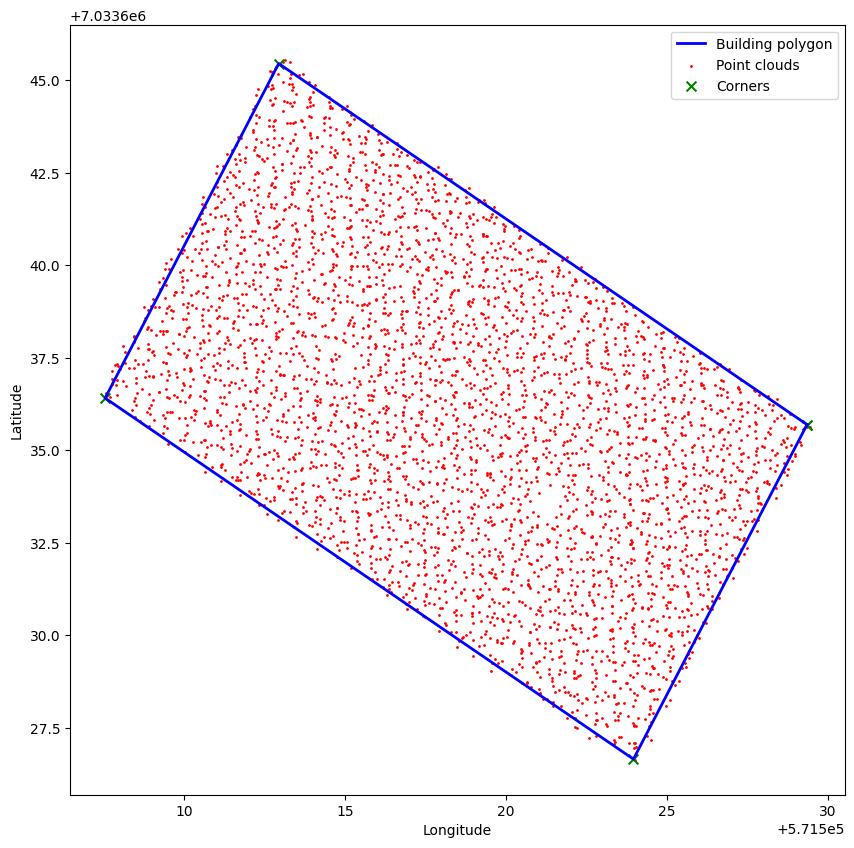

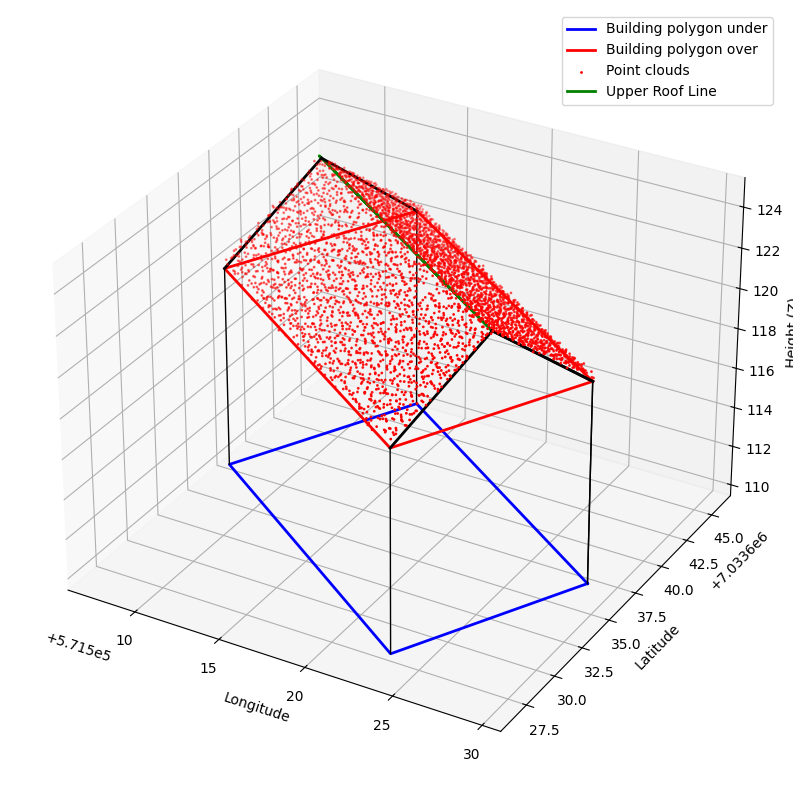

In [9]:

for i, row in combined_footprint_pointcloud.iterrows():
    polygon = row["geometry"] 
    points_x = row["x"]  
    points_y = row["y"]  
    points_z = row["z"] 
    min_z = row["min_z"]
    max_z = row["max_z"]

    
    if polygon is not None and polygon.geom_type == "Polygon" :  
        x_fkb, y_fkb = polygon.exterior.xy 

        corners = [Point(x, y) for x, y in polygon.exterior.coords]
        corner_x = [point.x for point in corners]  
        corner_y = [point.y for point in corners] 

        max_z = np.max(points_z)  

        #2D plot    
        plt.figure(figsize=(10, 10))
        plt.plot(x_fkb, y_fkb, color="blue", linewidth=2, label=f"Building polygon")
        plt.scatter(points_x, points_y, color="red", s=1, label="Point clouds")
        plt.scatter(corner_x, corner_y, color="green", s=50, marker="x", label="Corners")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.legend()
        plt.show()
       


        #3D plot
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection="3d")
        ax.plot(x_fkb, y_fkb, zs=min_z-10, color="blue", linewidth=2, label=f"Building polygon under")
        ax.plot(x_fkb, y_fkb, zs=min_z, color="red", linewidth=2, label=f"Building polygon over")
        ax.scatter(points_x, points_y, points_z, color="red", s=1, label="Point clouds")
        
        for x, y in zip(corner_x, corner_y):
            ax.plot([x, x], [y, y], [min_z-10, min_z], color="black", linewidth=1)
        
        
        if "upper_line" in row and isinstance(row["upper_line"], LineString):
            upper_x, upper_y = row["upper_line"].xy 
            upper_x = np.array(upper_x)
            upper_y = np.array(upper_y)
            upper_z = [max_z] * len(upper_x)  
            ax.plot(upper_x, upper_y, upper_z, color='green', linewidth=2, label='Upper Roof Line')

            for cx, cy in zip(corner_x, corner_y):
                closest_idx = np.argmin(np.sqrt((upper_x - cx) ** 2 + (upper_y - cy) ** 2)) 
                ax.plot([cx, upper_x[closest_idx]], 
                        [cy, upper_y[closest_idx]], 
                        [min_z, max_z],  
                        color="black", linewidth=2)

            ax.set_xlabel("Longitude")
            ax.set_ylabel("Latitude")
            ax.set_zlabel("Height (Z)")
            plt.legend()
            plt.show()
            break
            
        
        

### Results

/var/folders/yl/76yx_v411hg4ly7692g543600000gn/T/ipykernel_25600/1760927242.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


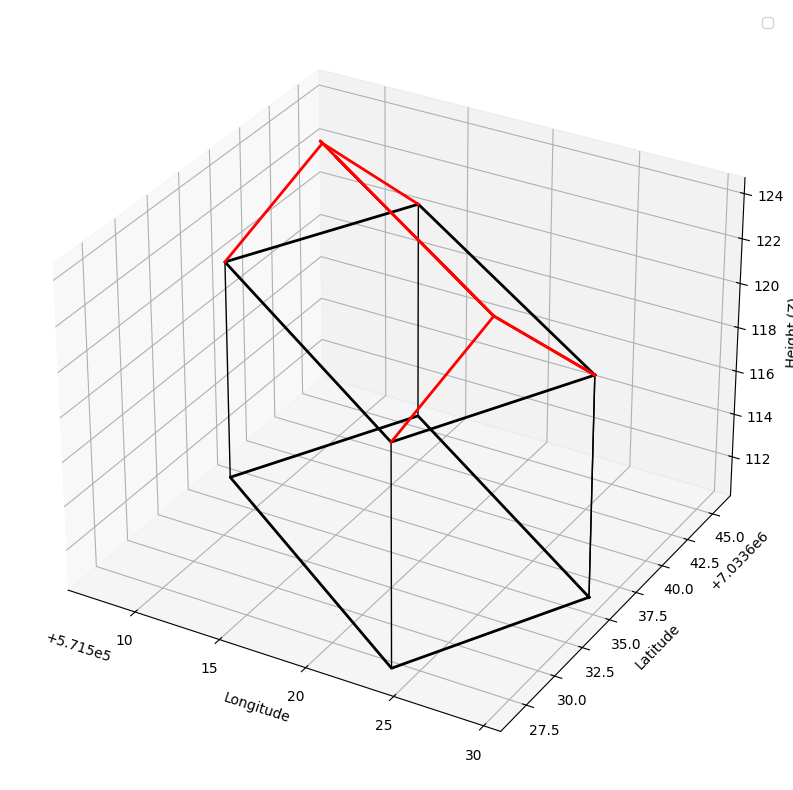

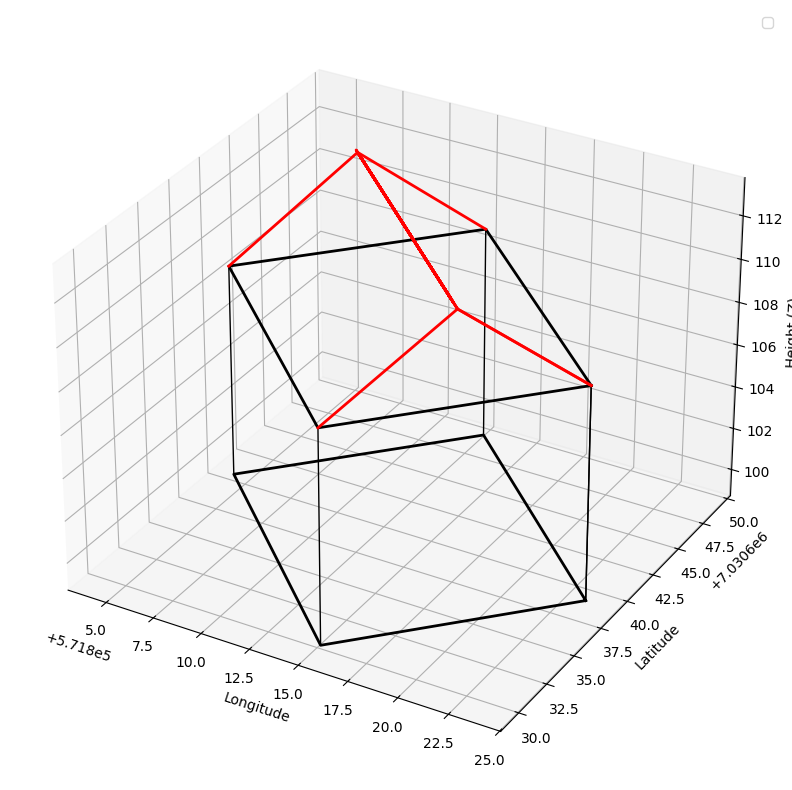

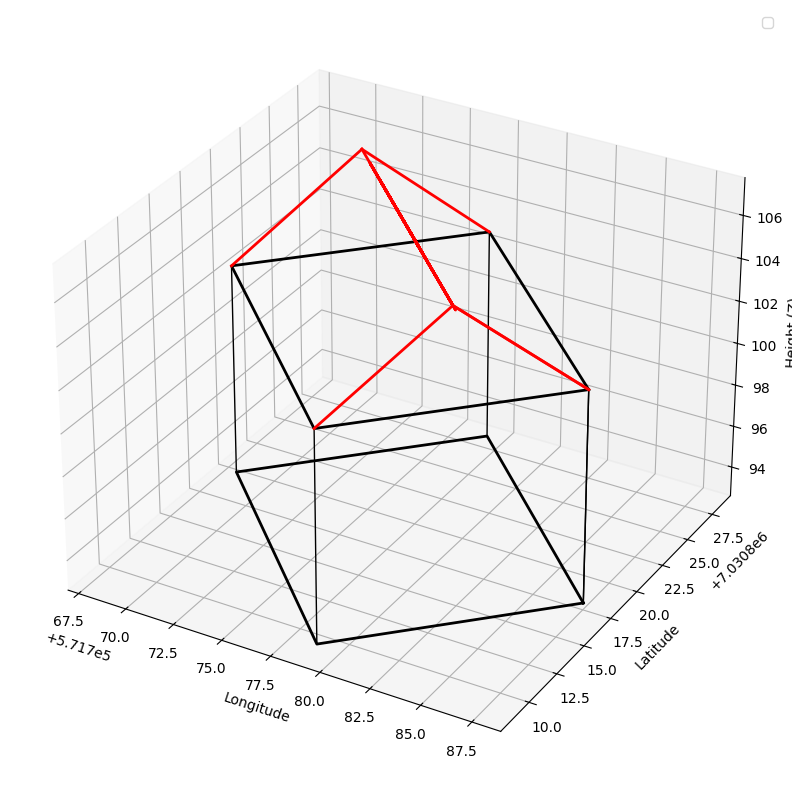

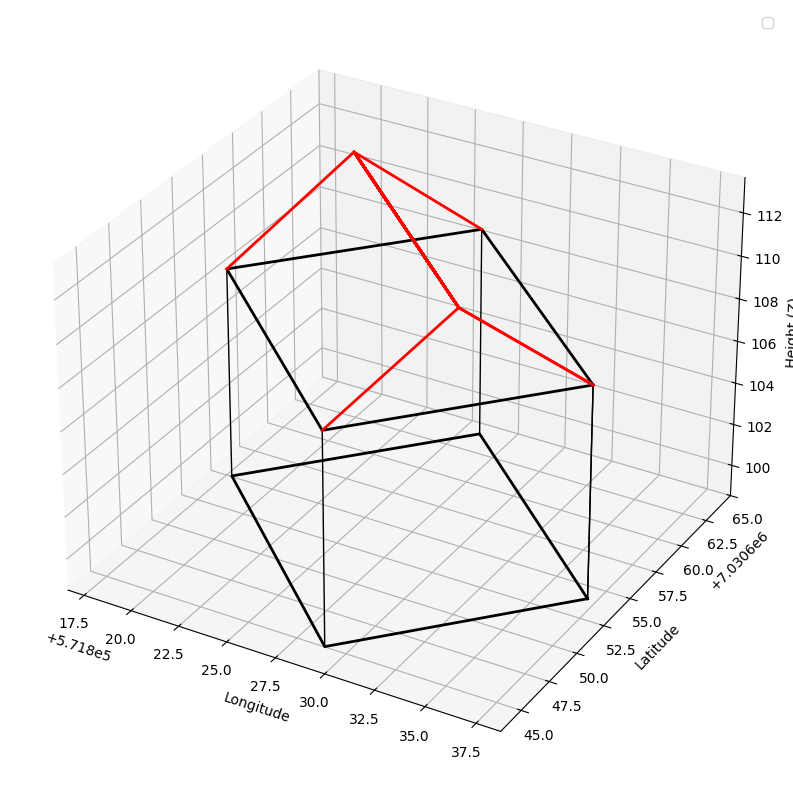

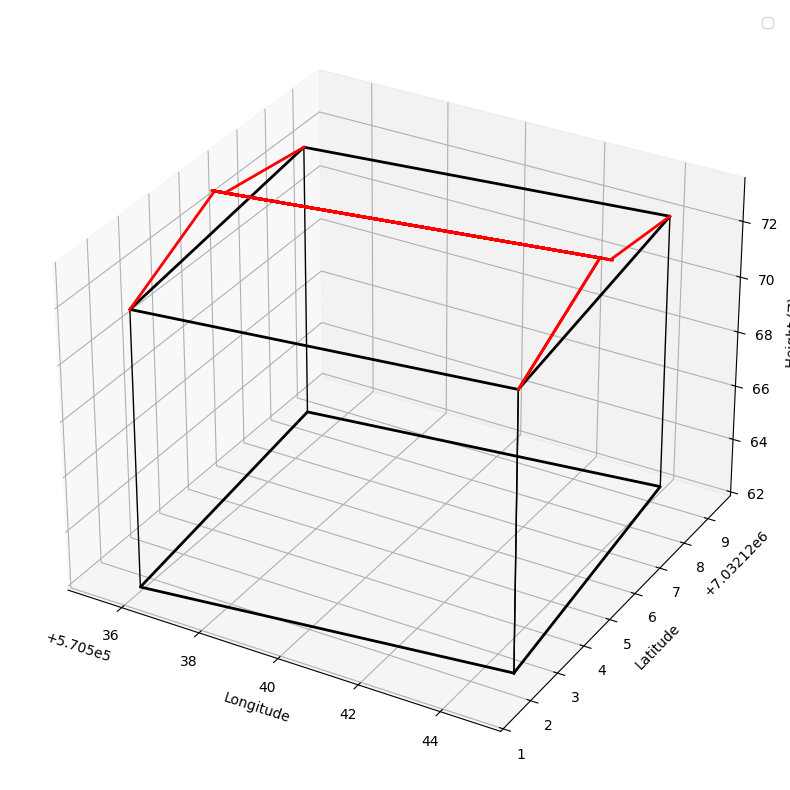

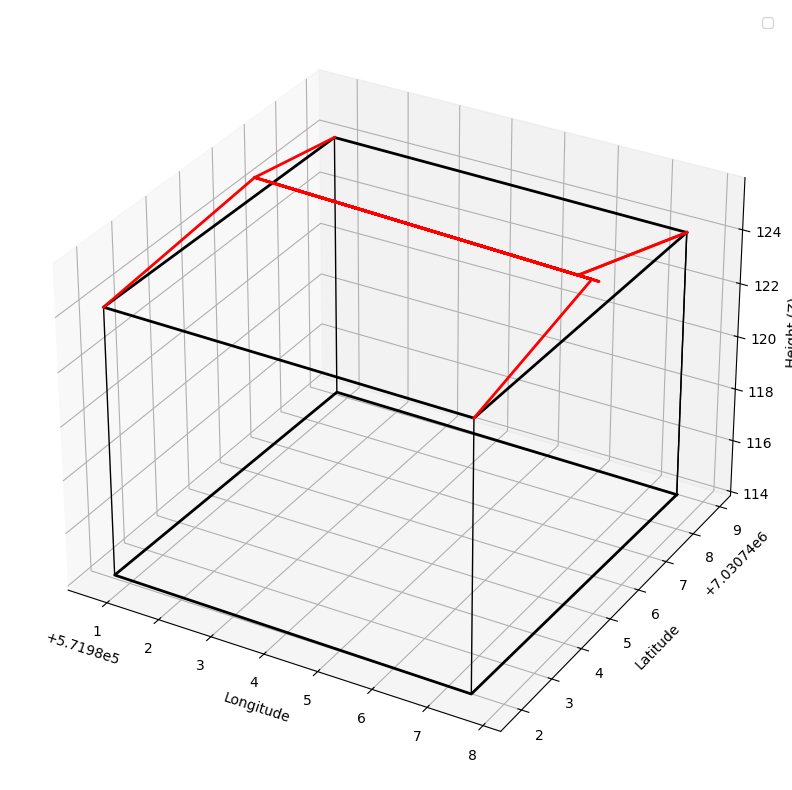

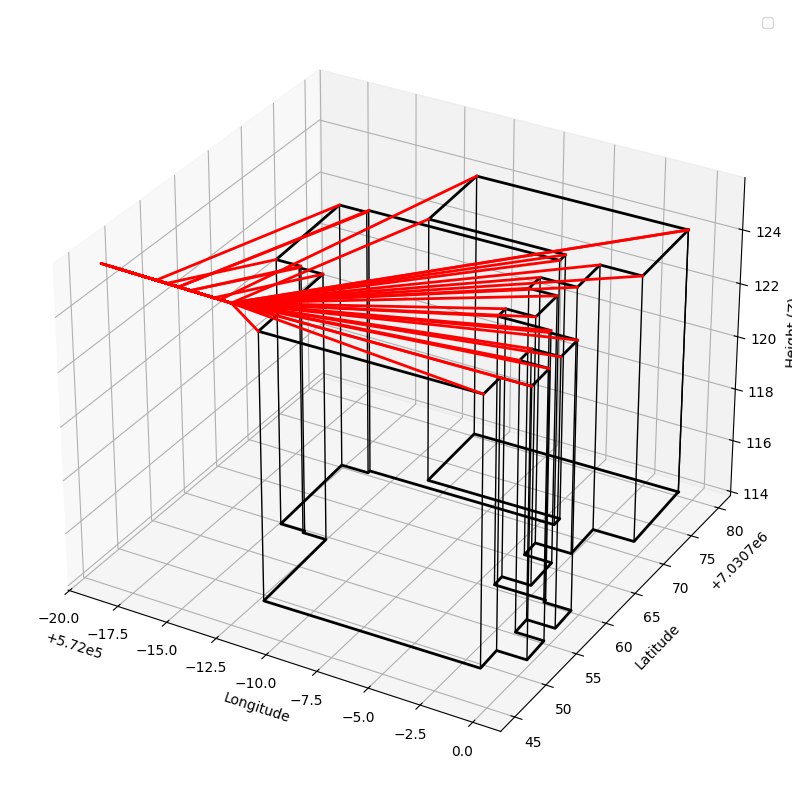

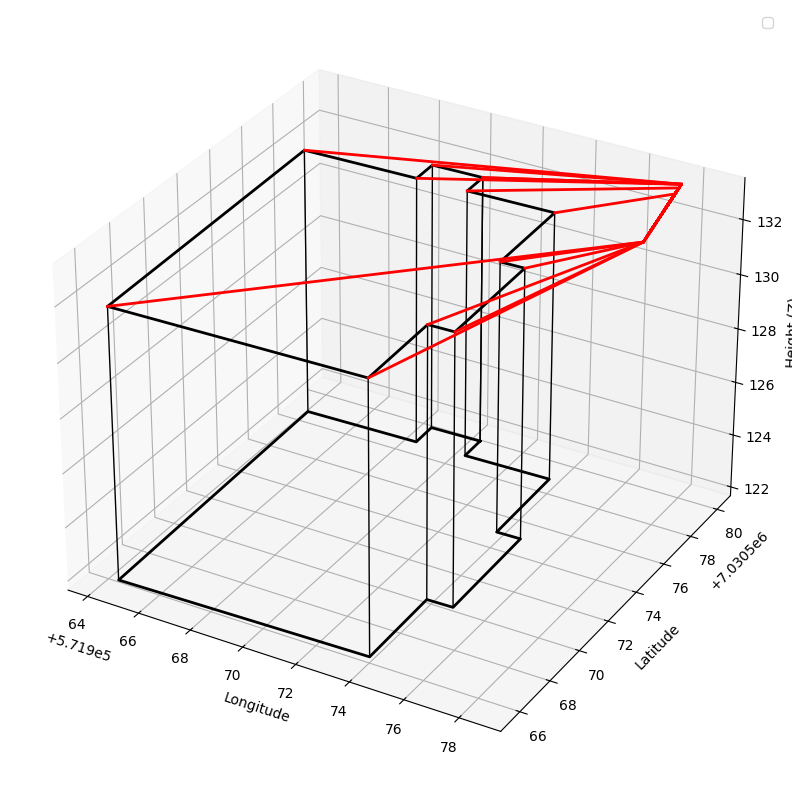

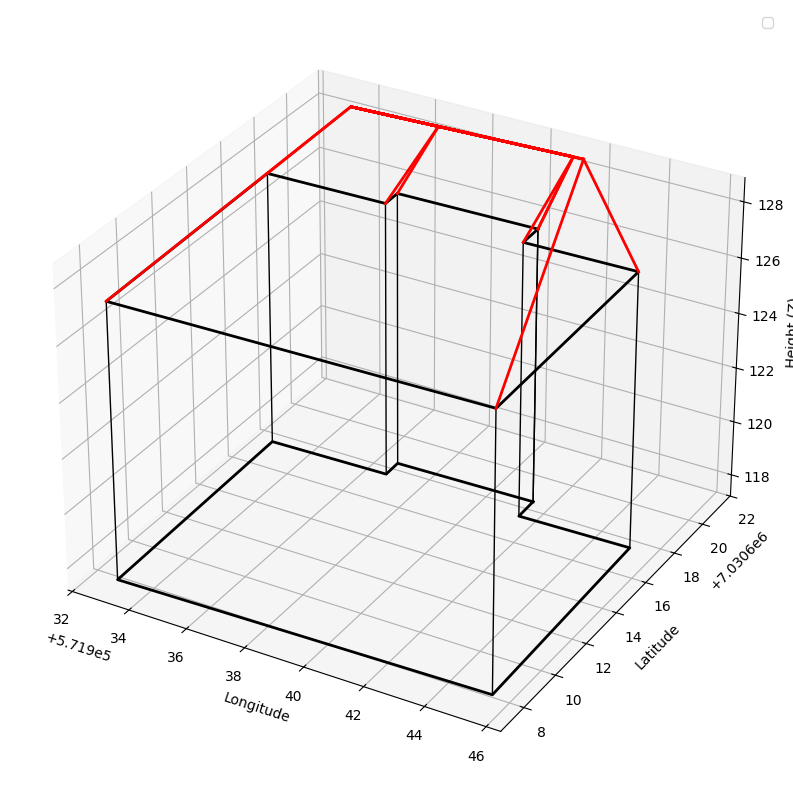

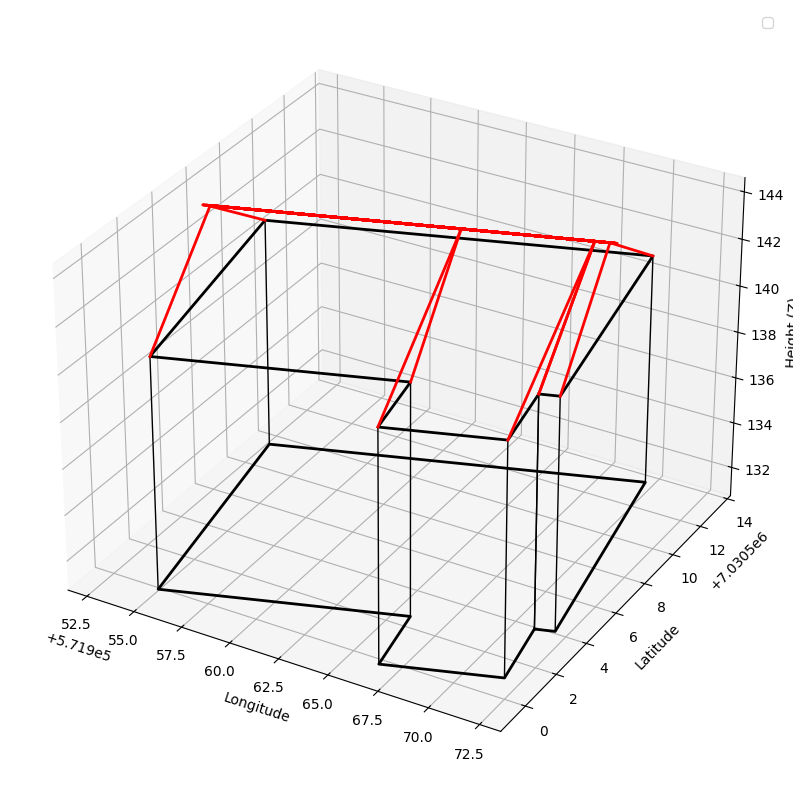

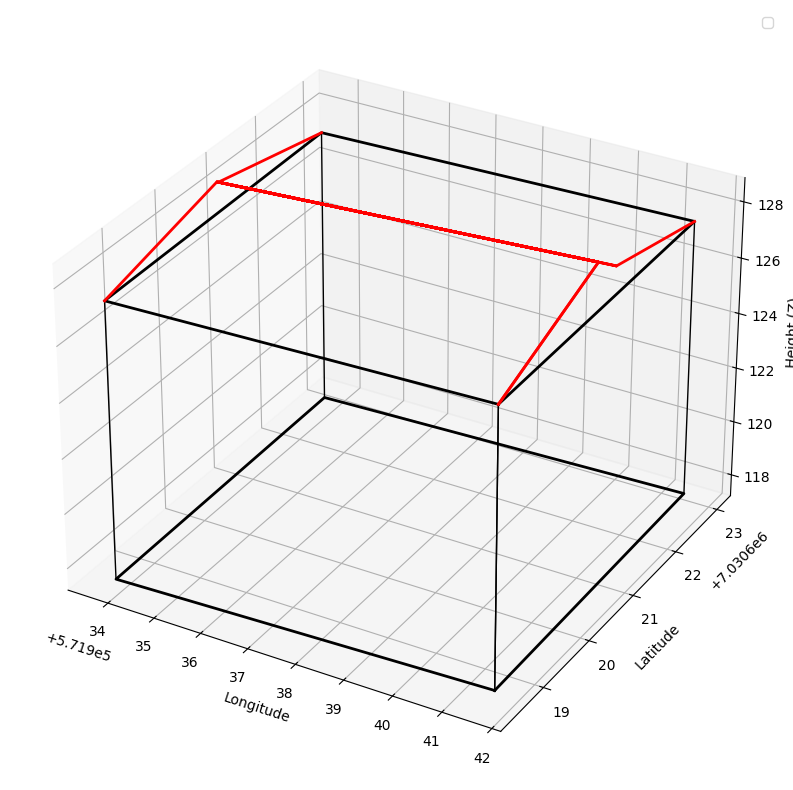

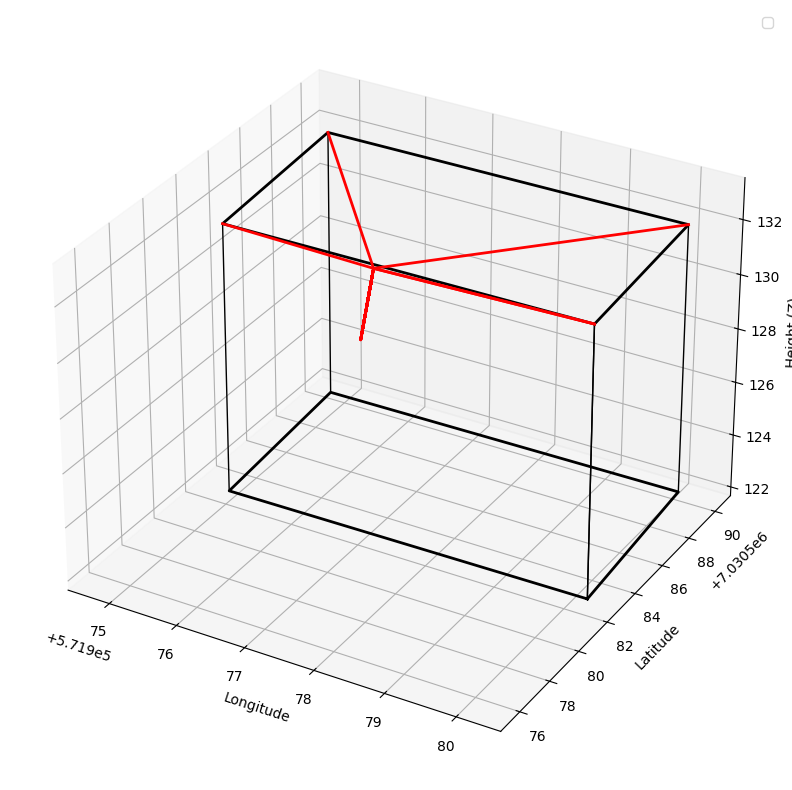

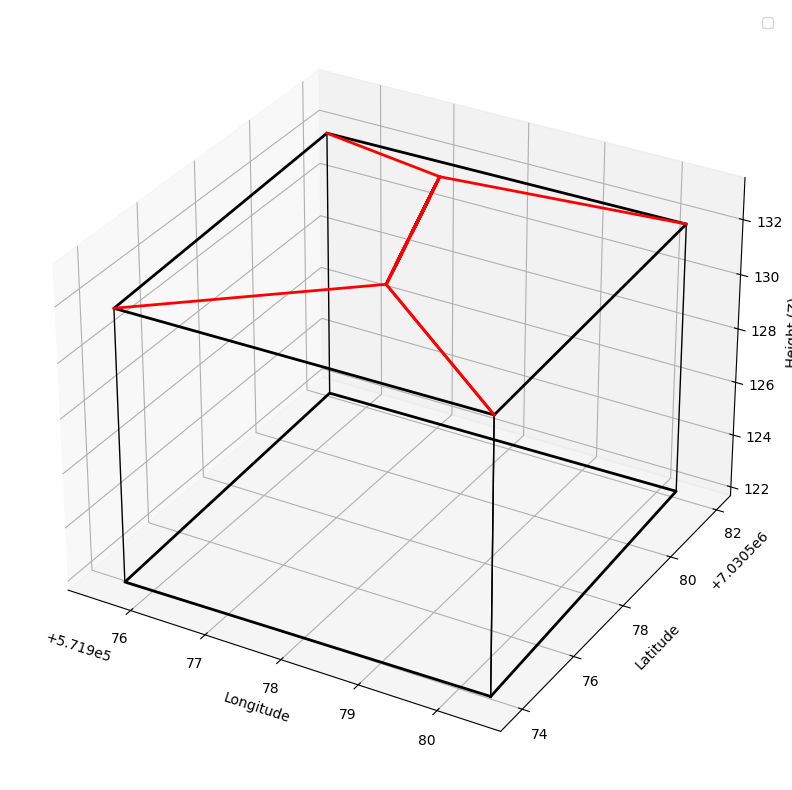

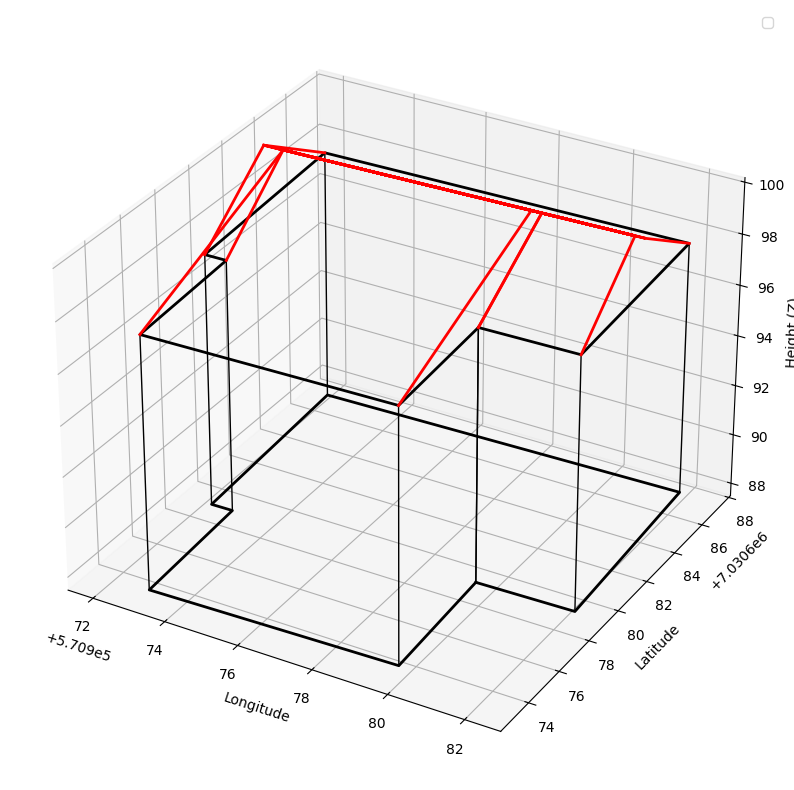

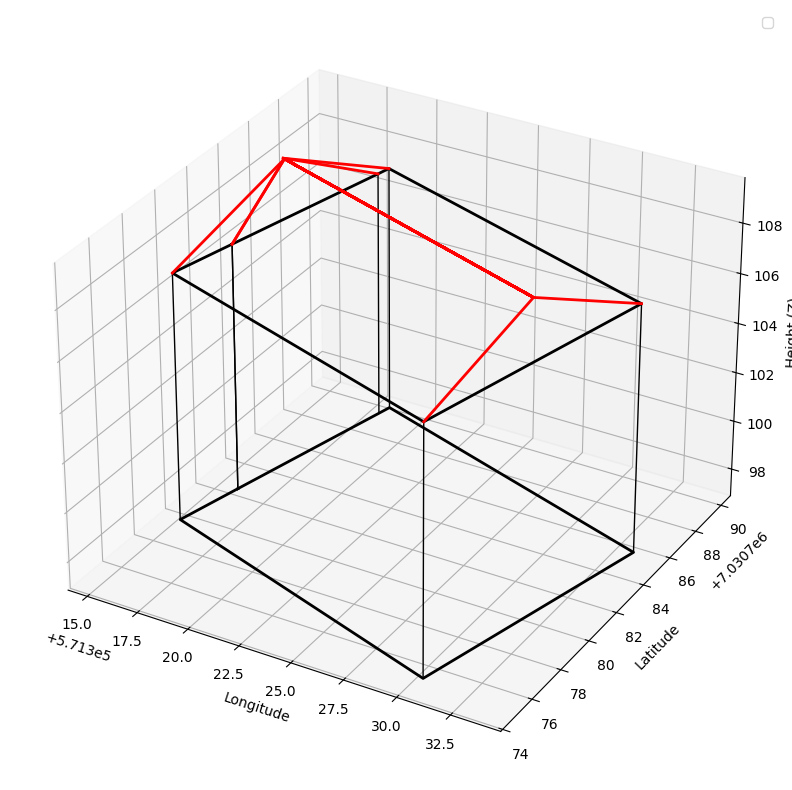

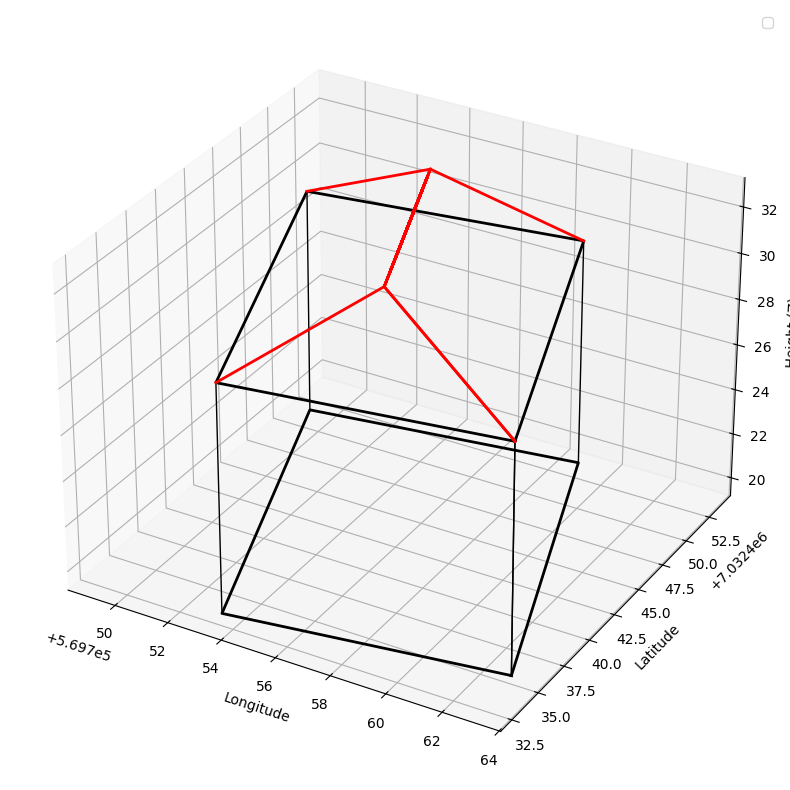

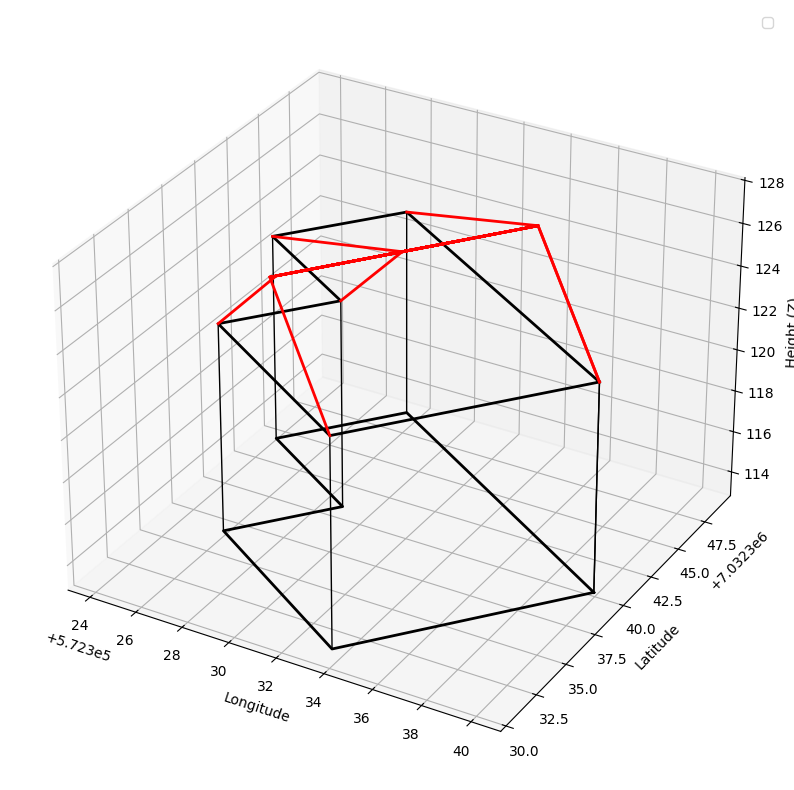

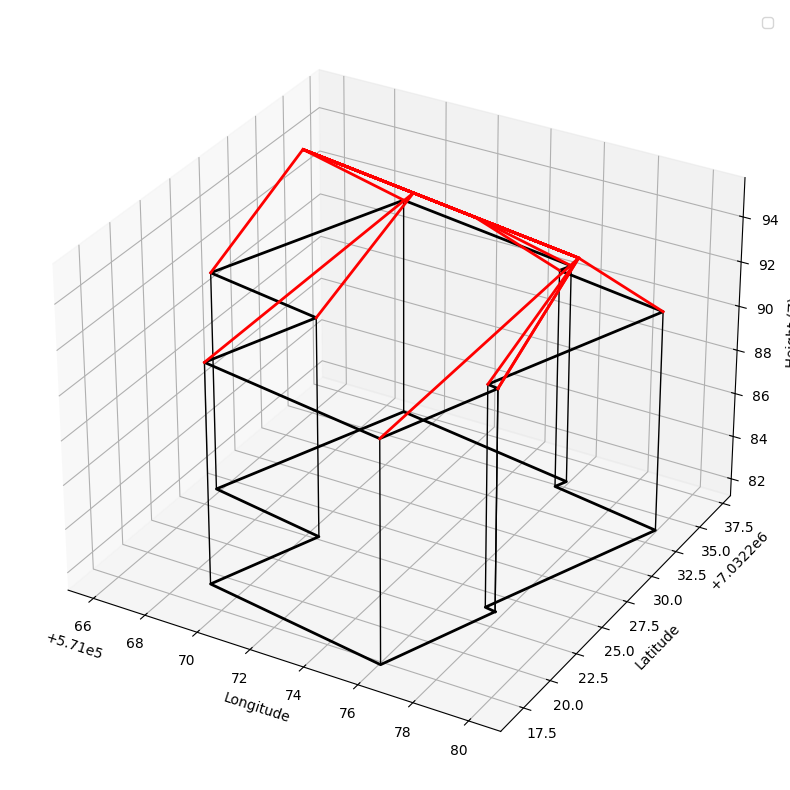

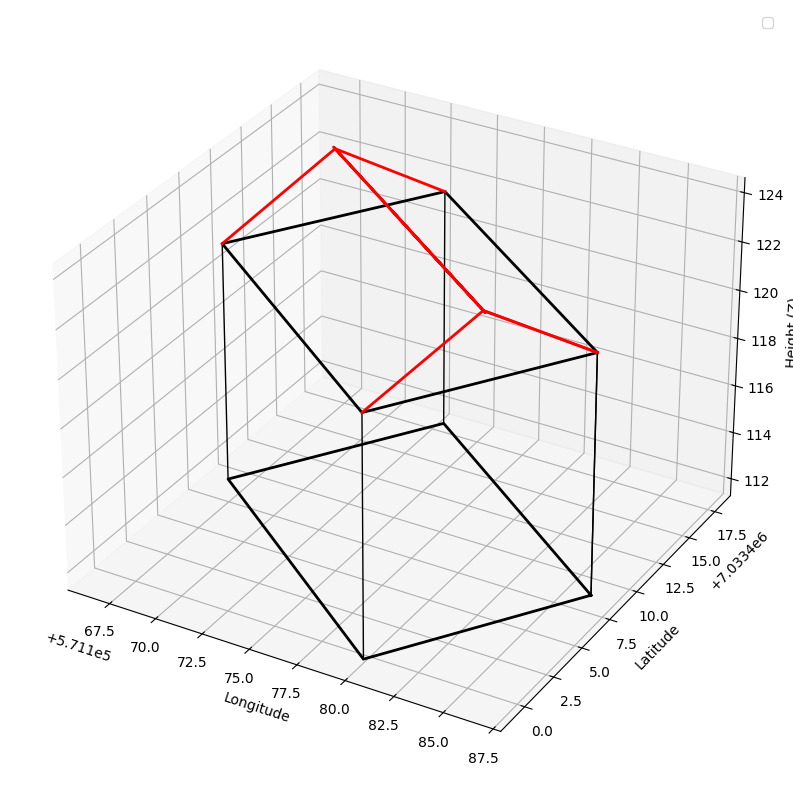

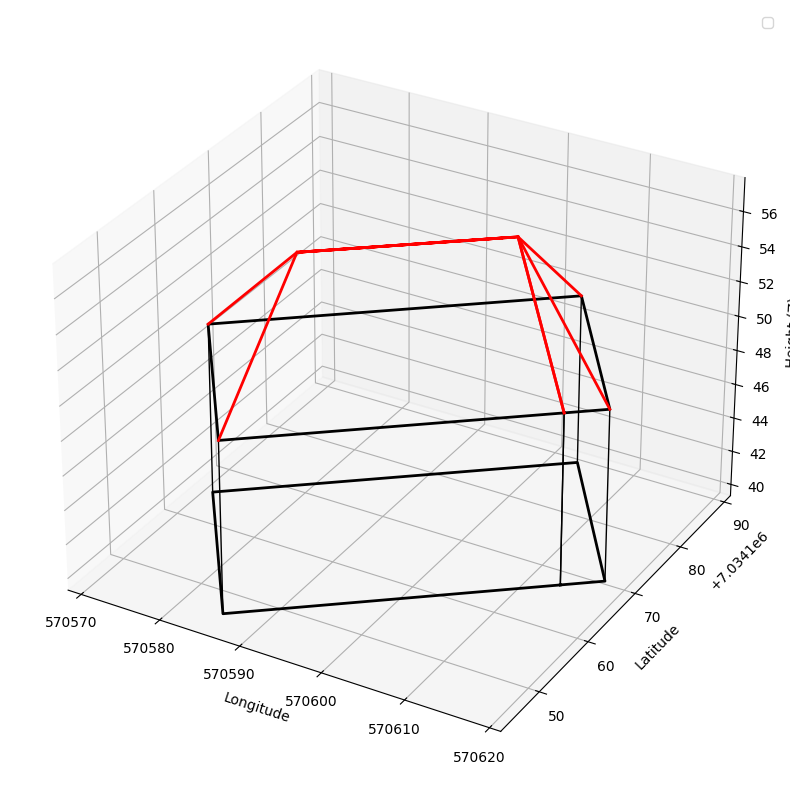

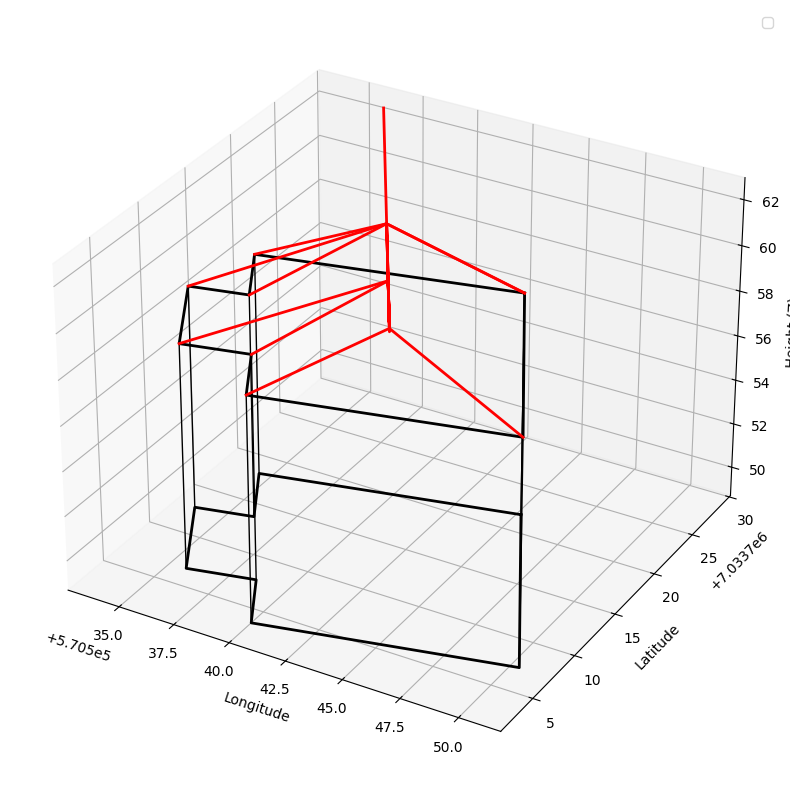

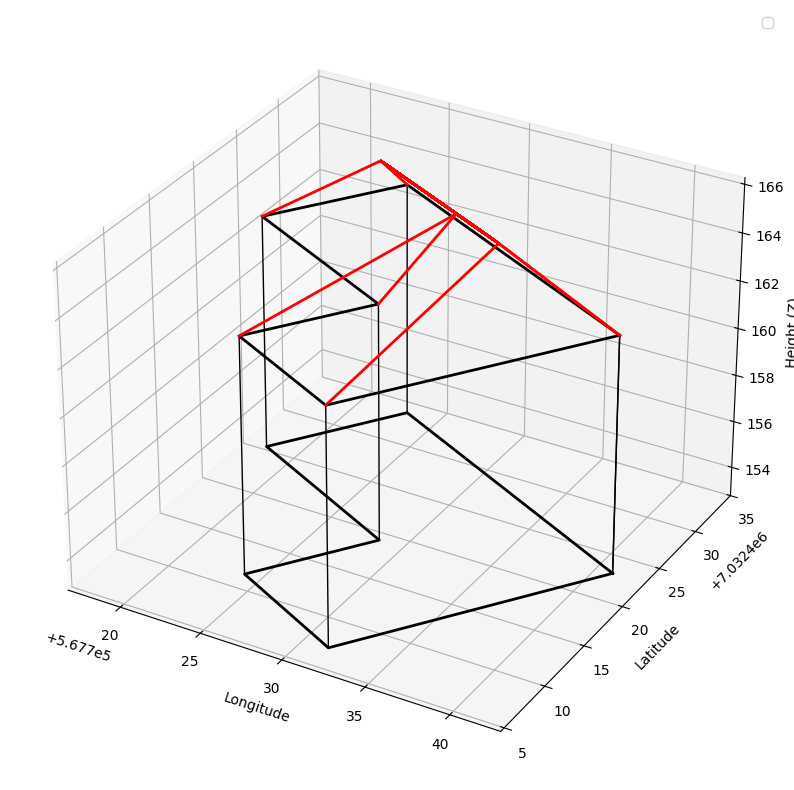

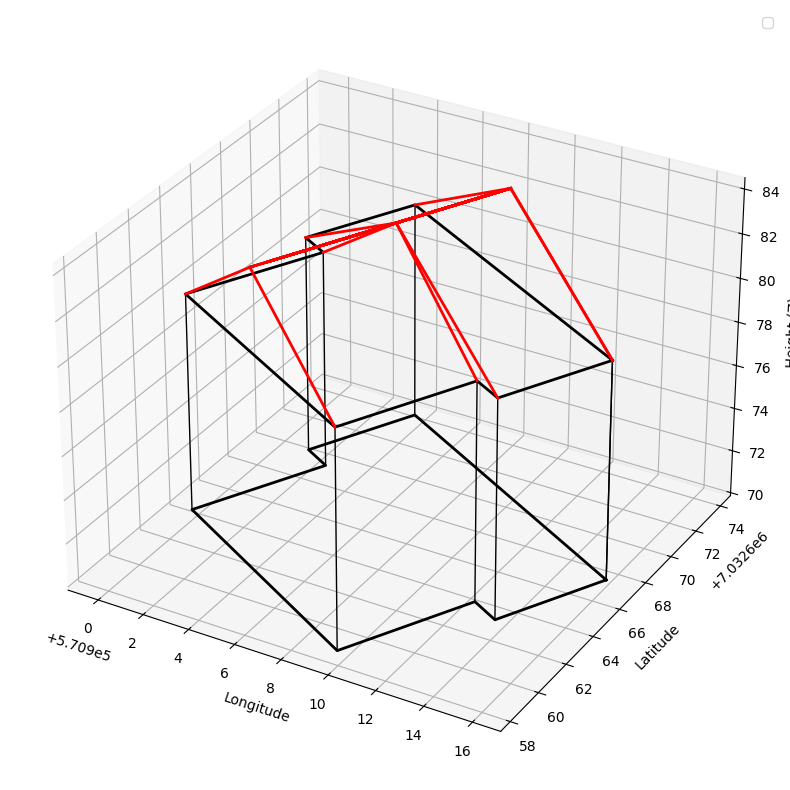

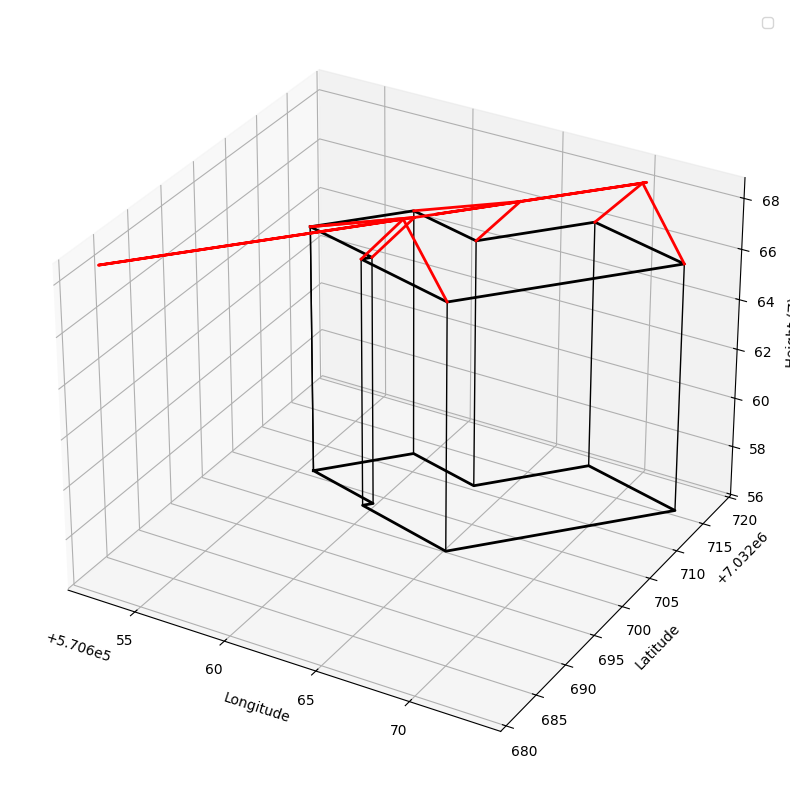

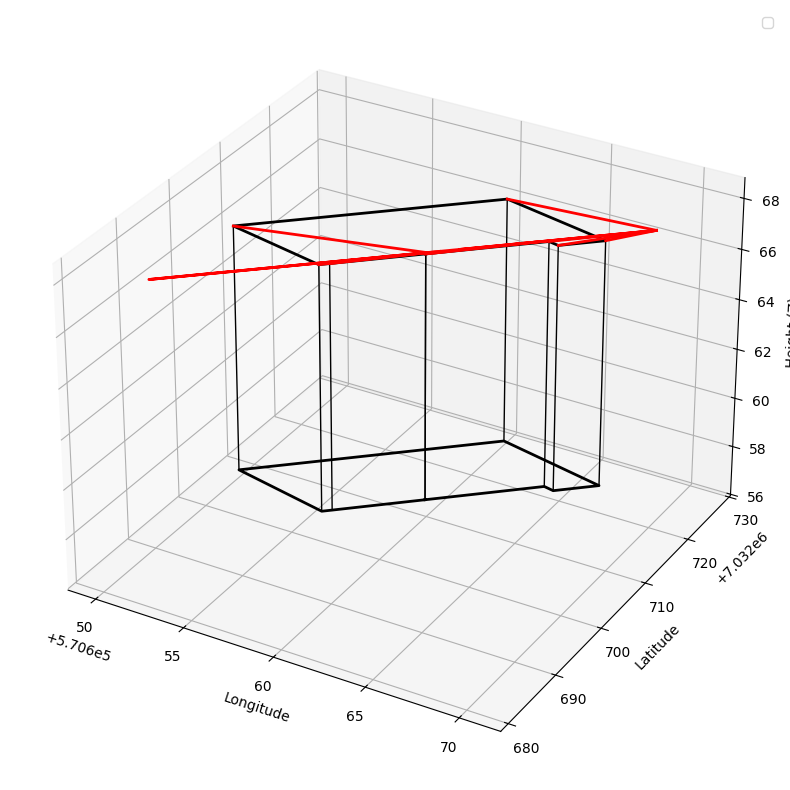

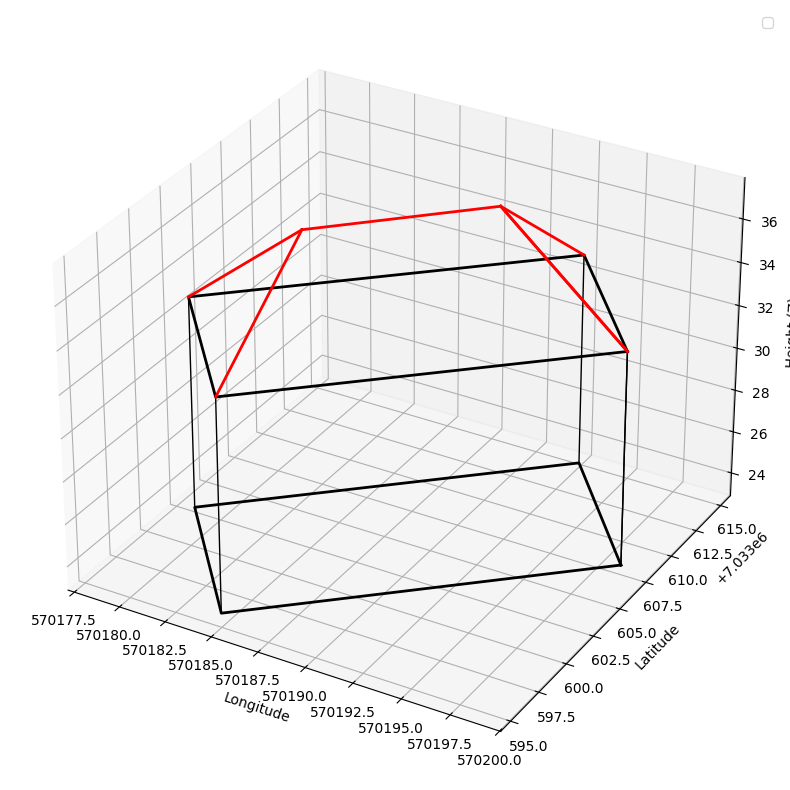

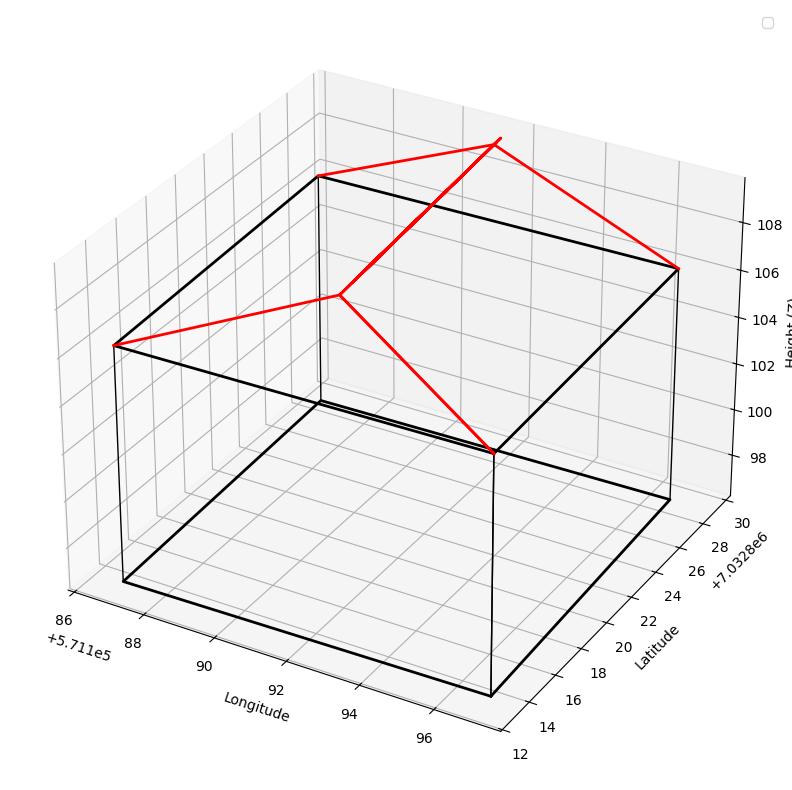

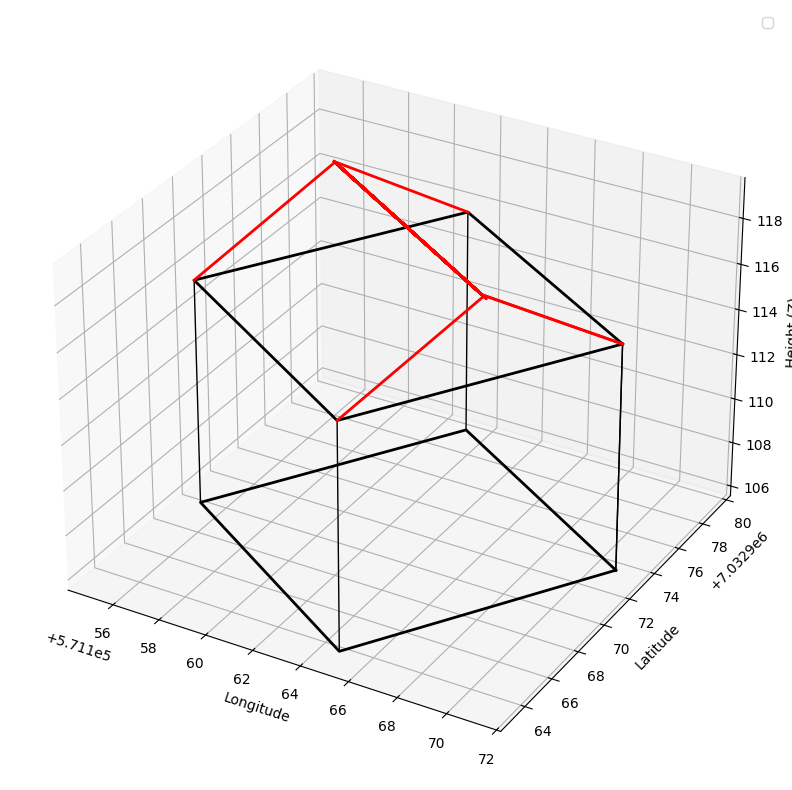

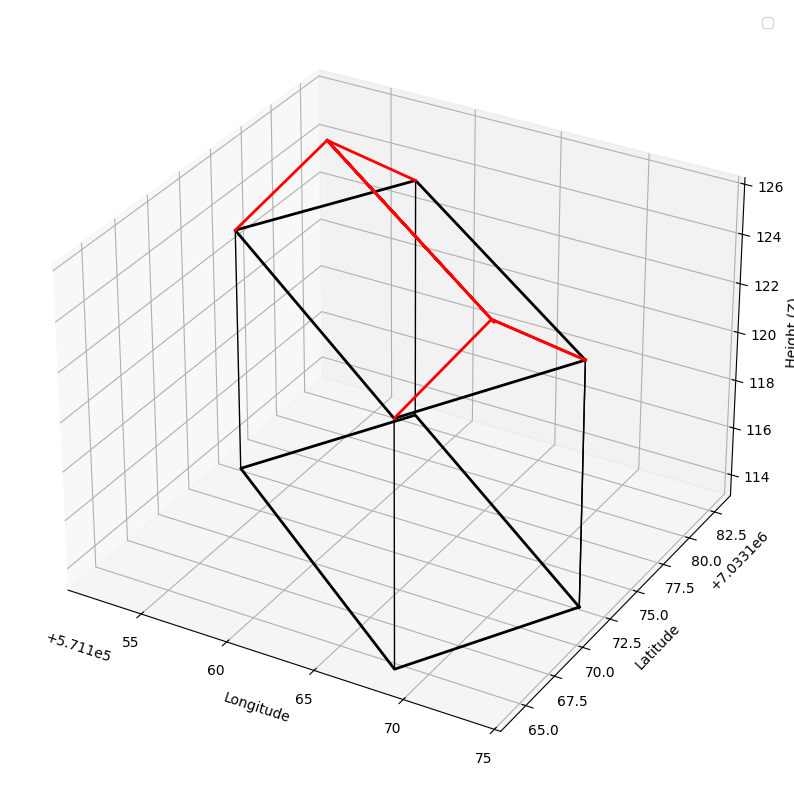

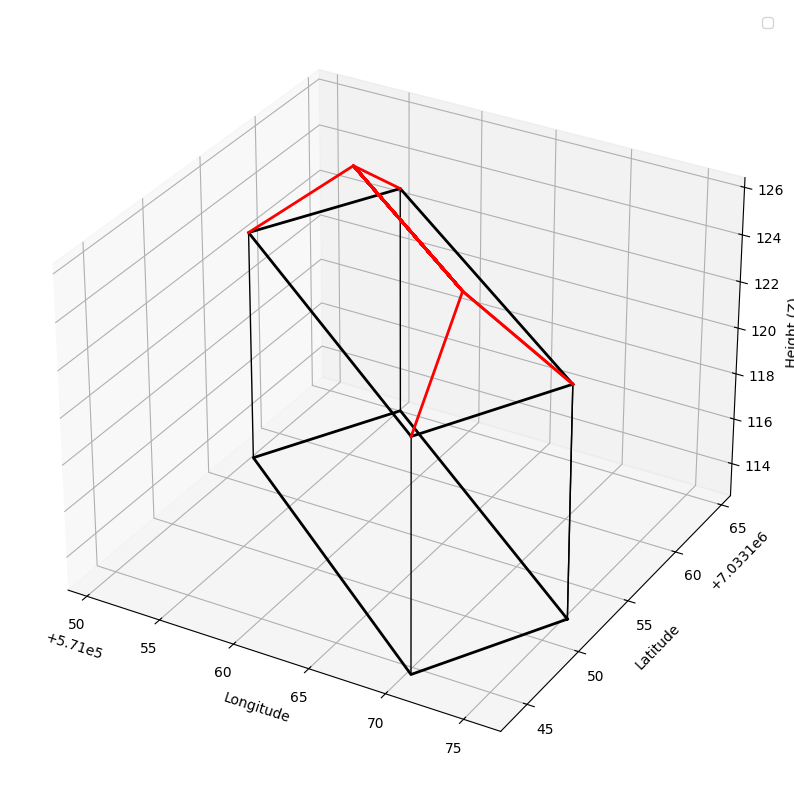

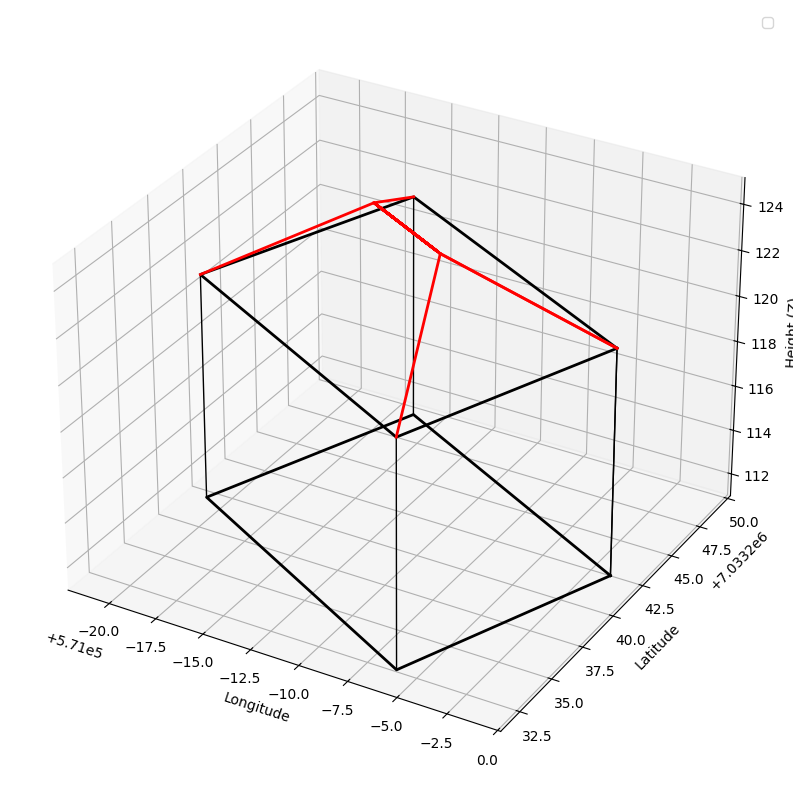

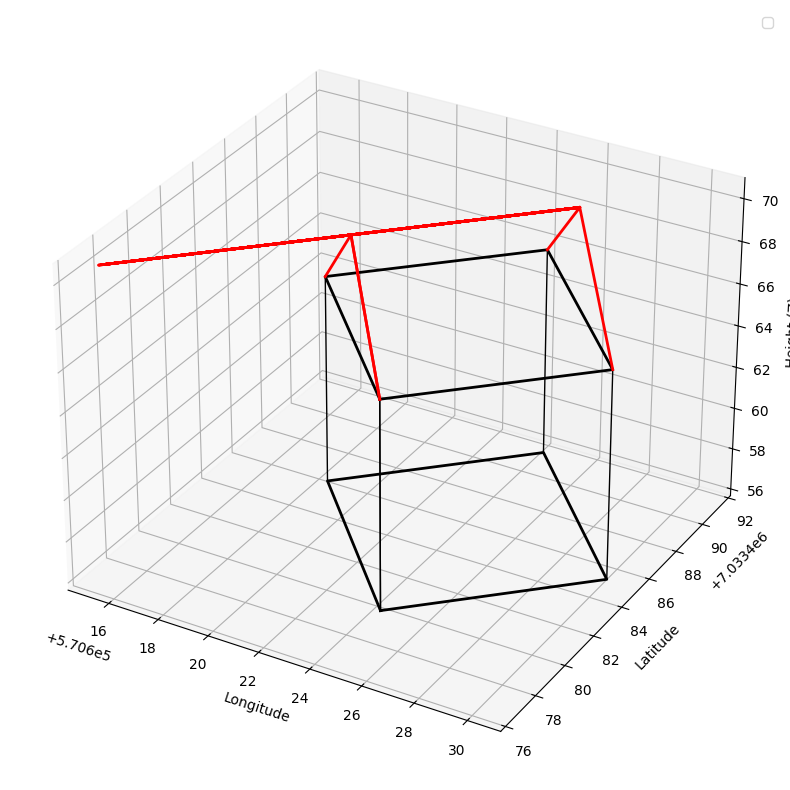

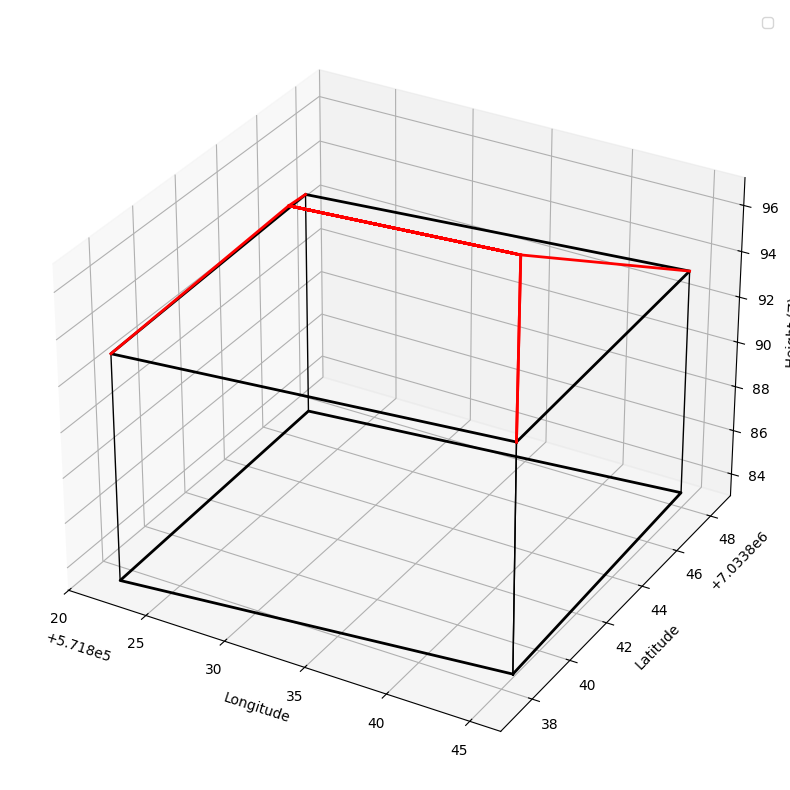

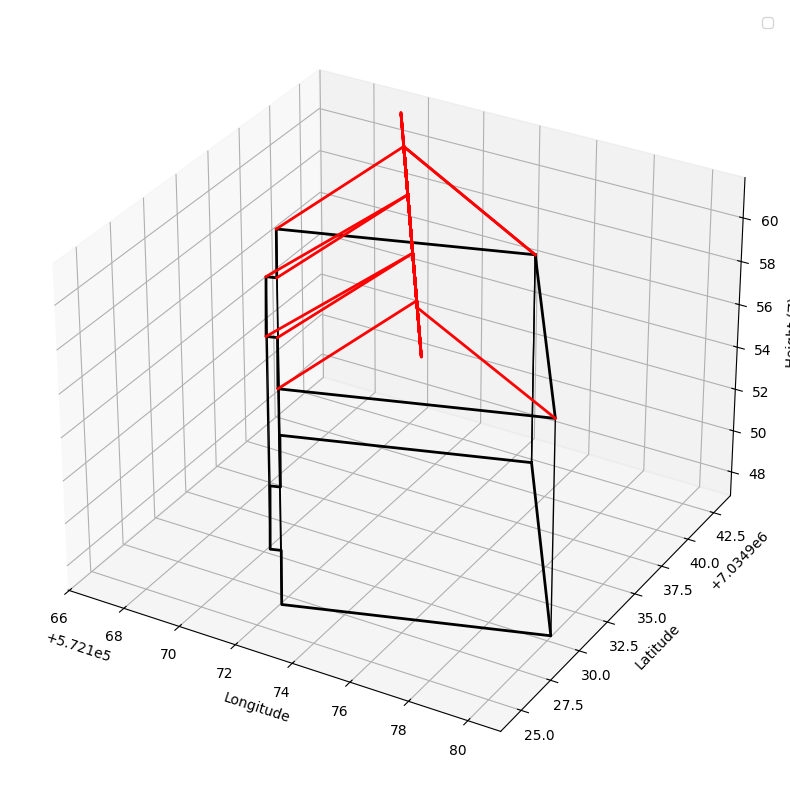

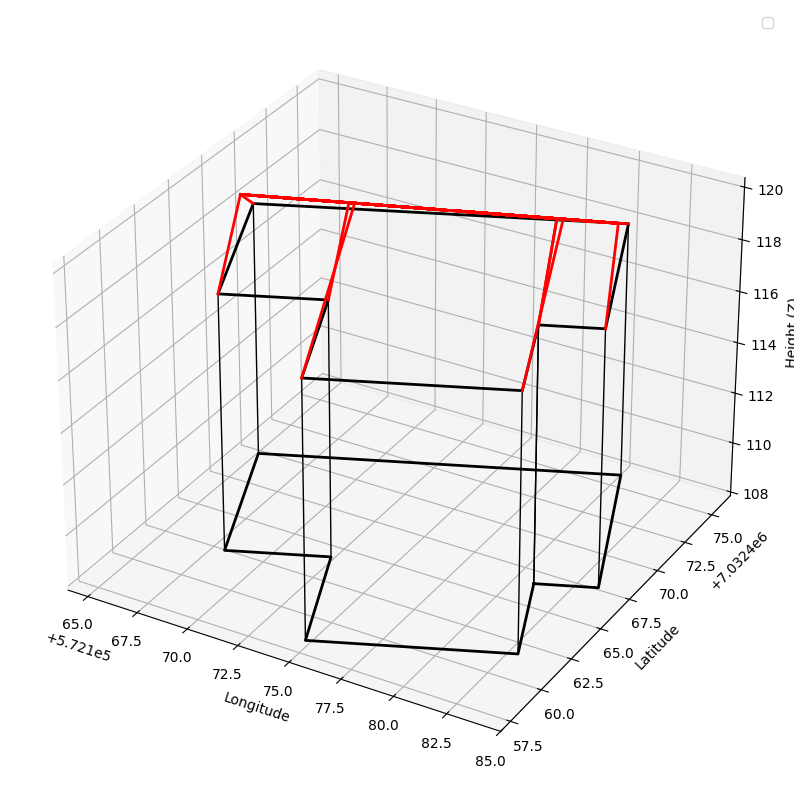

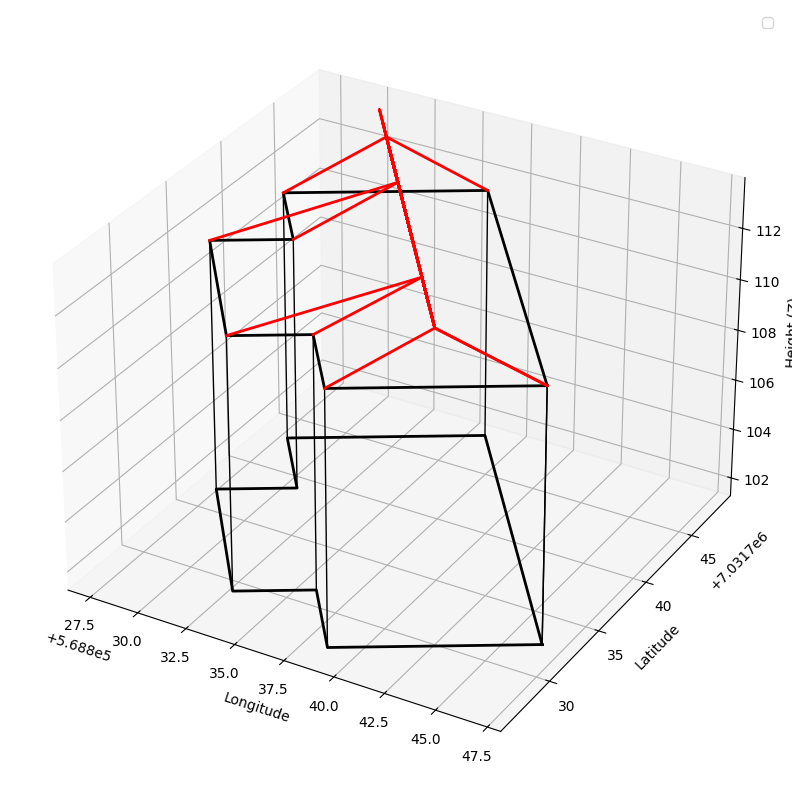

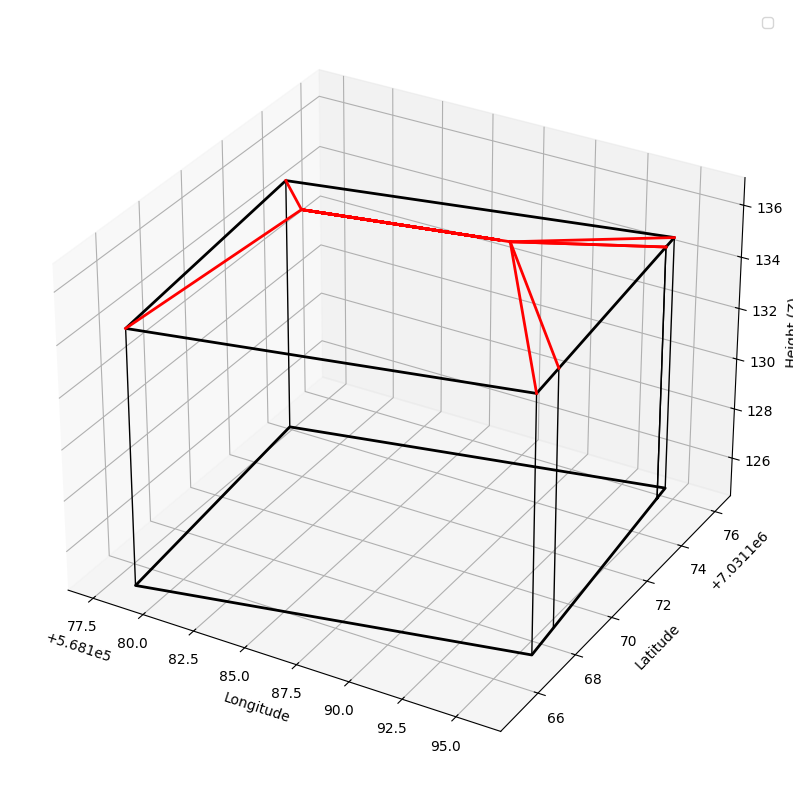

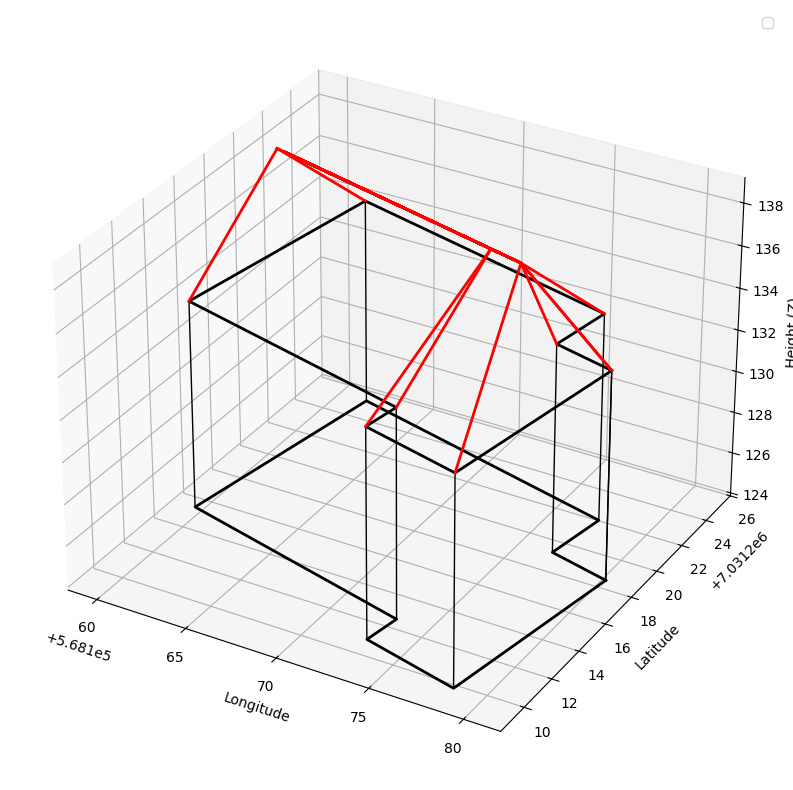

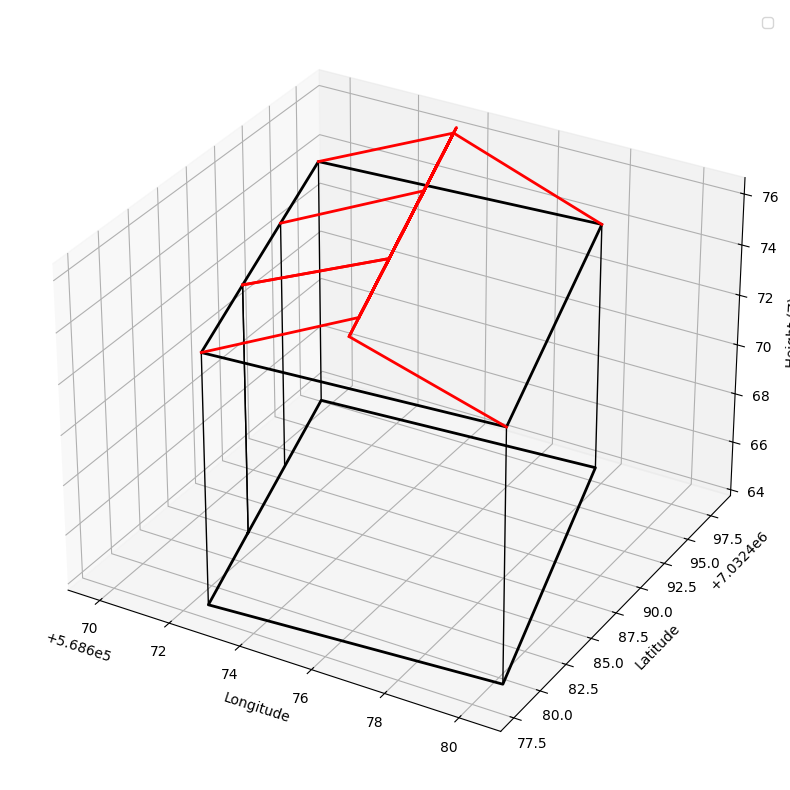

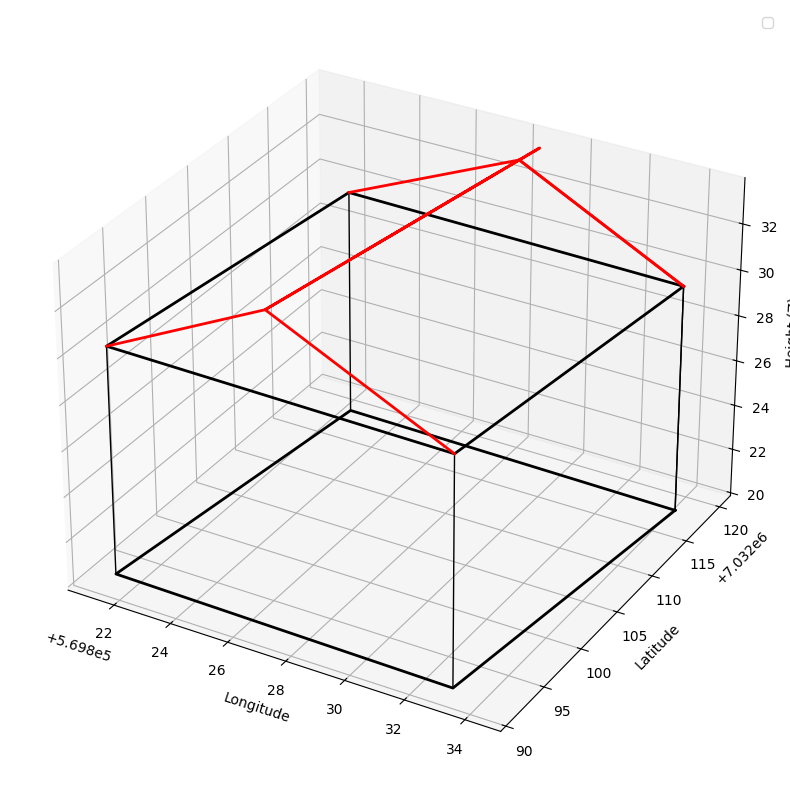

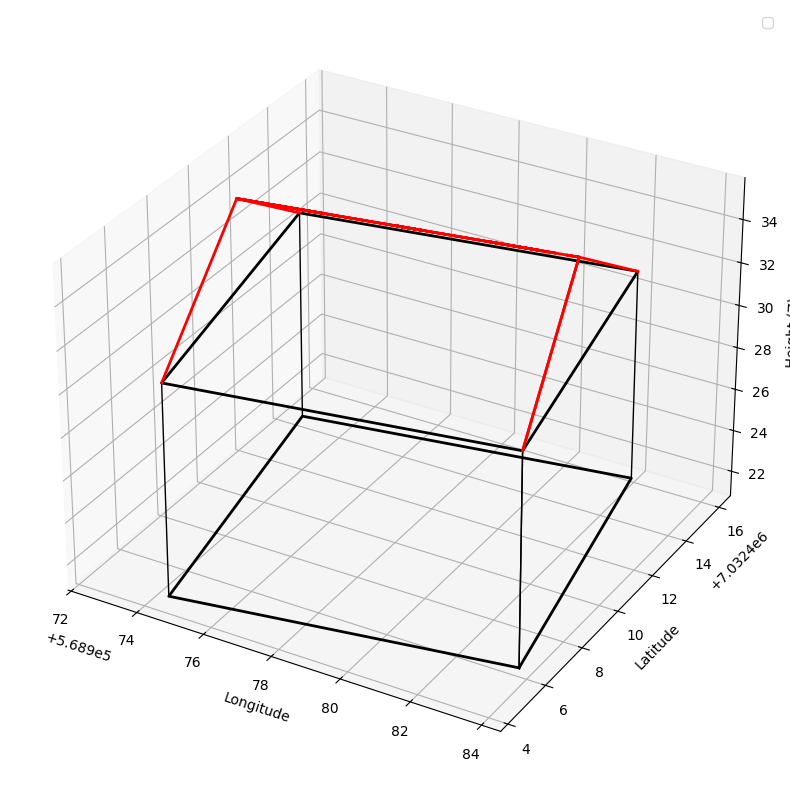

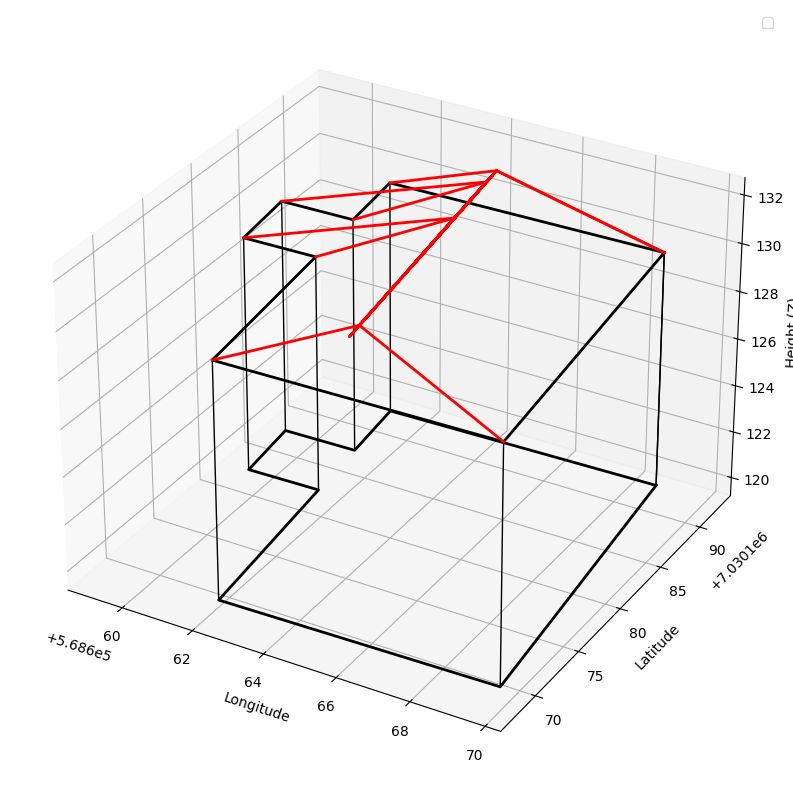

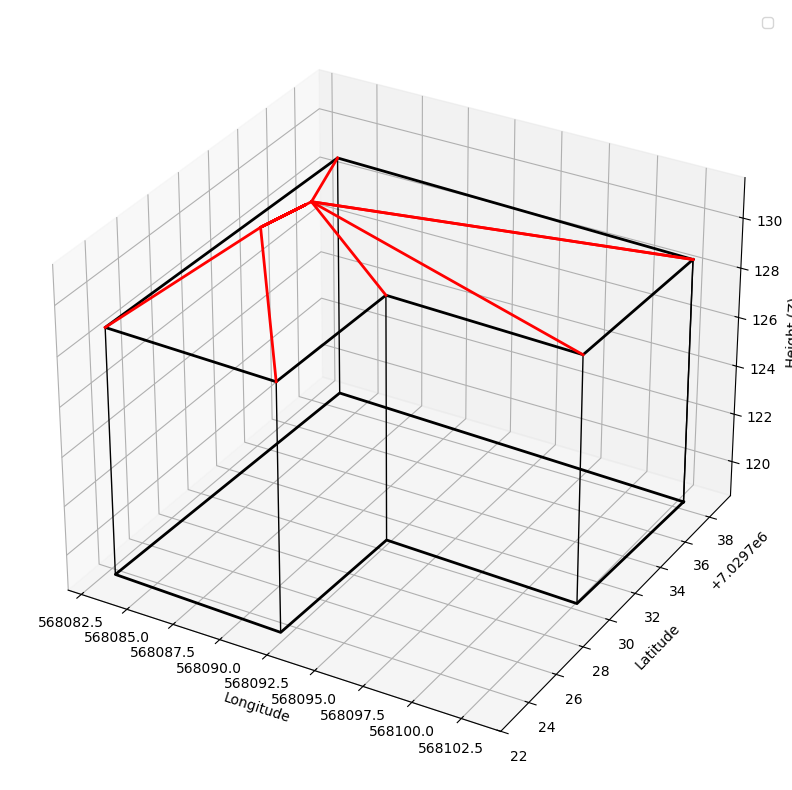

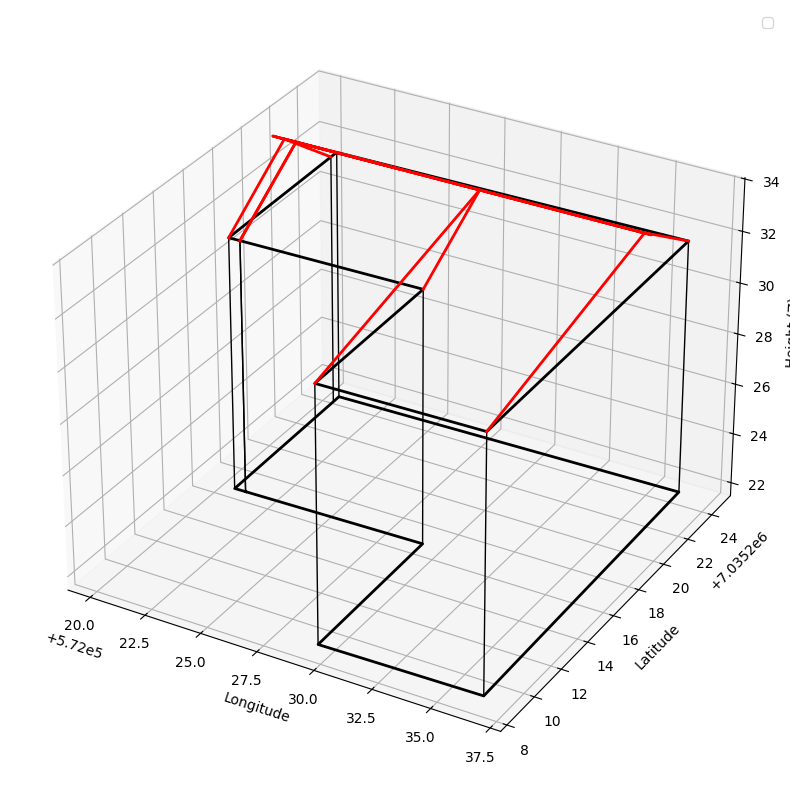

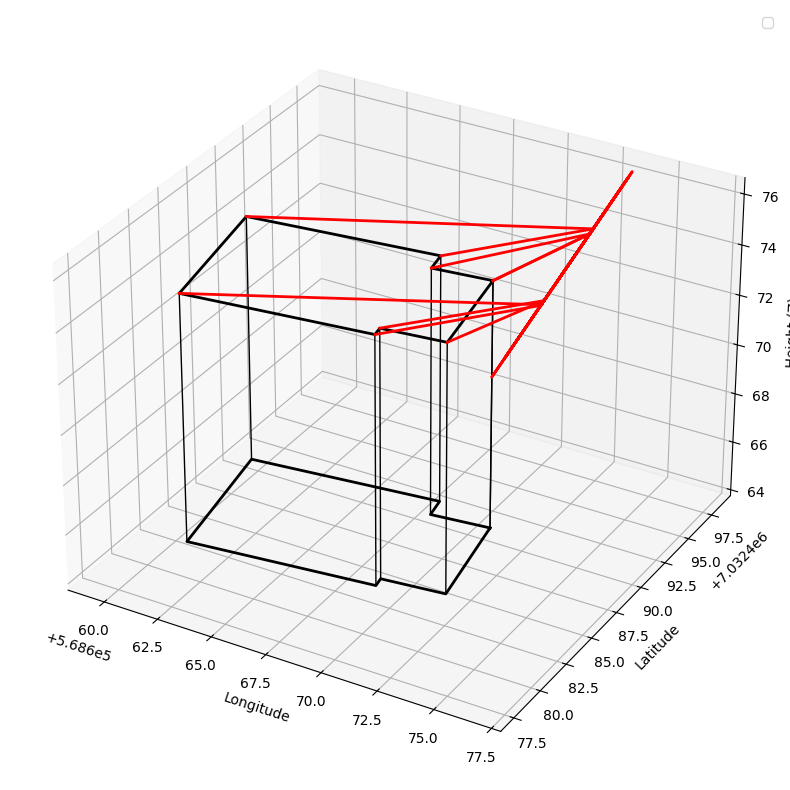

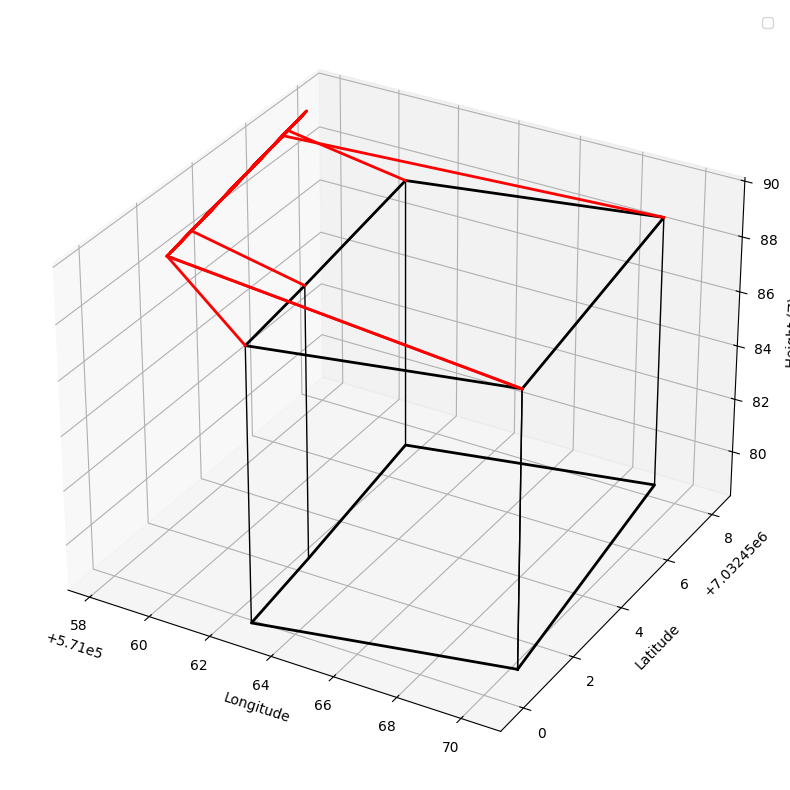

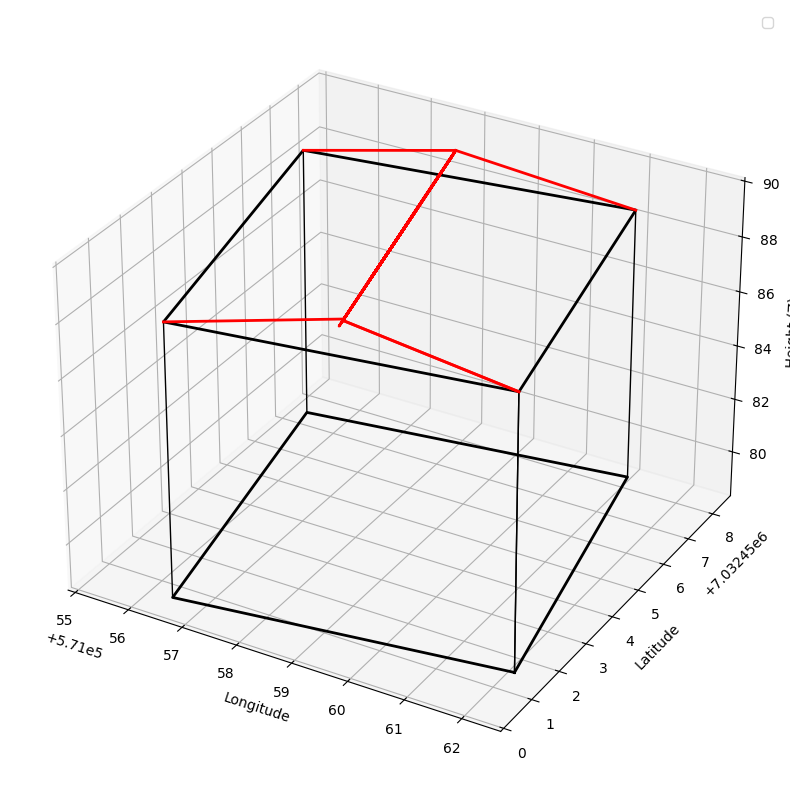

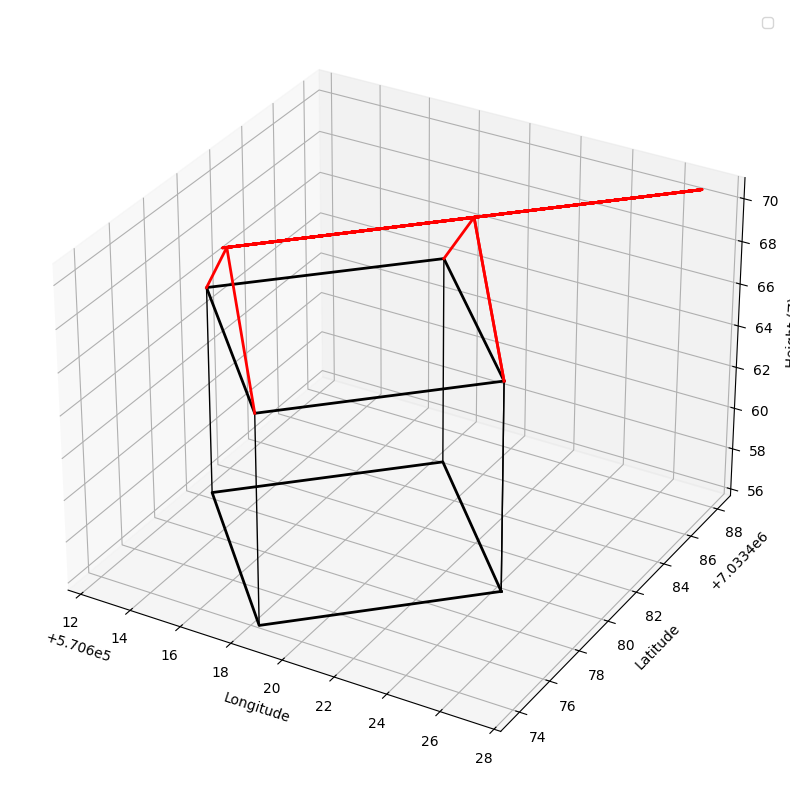

In [9]:


for i, row in combined_footprint_pointcloud.iterrows():
    polygon = row["geometry"]  
    points_x = row["x"]  
    points_y = row["y"] 
    points_z = row["z"]  
    min_z = row["min_z"]
    max_z = row["max_z"]

    if polygon is not None and polygon.geom_type == "Polygon":
        x_fkb, y_fkb = polygon.exterior.xy  
        corners = [Point(x, y) for x, y in polygon.exterior.coords]
        corner_x = [point.x for point in corners]
        corner_y = [point.y for point in corners]
        max_z = np.max(points_z) 


        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection="3d")
        ax.plot(x_fkb, y_fkb, zs=min_z-10, color="black", linewidth=2)
        ax.plot(x_fkb, y_fkb, zs=min_z, color="black", linewidth=2)

        for x, y in zip(corner_x, corner_y):
            ax.plot([x, x], [y, y], [min_z-10, min_z], color="black", linewidth=1)
        
        if "upper_line" in row and isinstance(row["upper_line"], LineString):
            upper_x, upper_y = row["upper_line"].xy  
            upper_x = np.array(upper_x)
            upper_y = np.array(upper_y)
            upper_z = [max_z] * len(upper_x)
            ax.plot(upper_x, upper_y, upper_z, color='red', linewidth=2)

            for cx, cy in zip(corner_x, corner_y):
                closest_idx = np.argmin(np.sqrt((upper_x - cx) ** 2 + (upper_y - cy) ** 2))
                ax.plot([cx, upper_x[closest_idx]], 
                        [cy, upper_y[closest_idx]], 
                        [min_z, max_z], 
                        color="red", linewidth=2)

        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")
        ax.set_zlabel("Height (Z)")
        plt.legend()
        plt.show()
        